# Notebook setup

In [1]:
from pandas import Series, DataFrame
import pandas as pd

import numpy as np

# import rpy2.rinterface
%load_ext rpy2.ipython

# import random 
# import scipy.stats
# import math

from plotnine import ggplot, geom_histogram, aes,position_dodge, geom_bar, geom_rect,guides, guide_legend, scale_x_discrete,theme, element_text, element_blank,ggtitle, xlab, ylab, facet_wrap, geom_point, stat_smooth, annotate, geom_text, geom_boxplot, geom_col, facet_grid

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set working directory
# ------------------------------
os.chdir("../../")


In [4]:
# Set figure counter for text
# ------------------------------
figcounter = 1


# Introduction


Inversions can be classified in two groups depending on their generation process: two relatively close breaks that are repaired in opposite orientations by non-homologous mechanisms (which we call NH inversions), or non-allelic homologous recombination between inverted repeats (NAHR inversions). These two groups have differences regarding important characteristics such as size, location  and divergence between orientations. NH inversions are smaller, can appear anywhere in the genome and are unique, which causes a marked divergence between opposite orienations as time goes by. NAHR inversions appear under the specific conditions of having inverted repeats at a certain distance, but can be much bigger than NH inversions and can be generated more than once throughout the history of a population, which leads to less divergence between orientations <cite data-cite="Aguado2014"></cite><cite data-cite="Giner-Delgado2019"></cite>. 

In addition, inversions generate aberrant chromosomes and unviable zygotes if a recombination event takes place within the region during meiosis. Thus, they are expected to have better chances of reaching polymorphism in low recombination regions. On the other hand, a higher incidence of NAHR events can be expected in high recombination regions <cite data-cite="Sasaki2010"></cite>. 

In this report, I explore whether inversions are evenly distributed among chromosomes and which variables affect the generation and/or maintenance of inversions as polymorphisms in certain regions of the genome. 


# Data

In [1]:
# CONTENT: Upload data
#----------------------------------------
#----------------------------------------


# Load chromosome data
# -------------------------------

gap = pd.read_csv('data/raw/gap.txt', sep = '\t', header = None )
gap.set_axis(['bin','chrom','chromStart','chromEnd','ix','n','size','type','bridge'], axis = 1, inplace = True)

band = pd.read_csv('data/raw/cytoBand.txt', sep = '\t', header = None )
band.set_axis(['chrom','chromStart','chromEnd','name','gieStain'], axis = 1, inplace = True)

sizes = pd.read_csv('data/raw/chrSizes.txt', sep = '\t')

genSize = pd.read_csv("data/use/BhererGeneticDistance.txt", sep = "\t", header = None)
genSize.set_axis(["Chromosome", "Position", "Rate", "cM"] ,axis = 1, inplace = True)

recRate = pd.read_csv("data/use/BhererAllChroms.txt", sep = "\t", header = None)
recRate.set_axis(["Chromosome", "Position", "Rate", "cM"] ,axis = 1, inplace = True)

# Load repeat data
# -------------------------------

segDups = pd.read_csv('data/raw/genomicSuperDups.txt', sep = '\t'  )

# Load and clean inversion data
# -------------------------------

inv = pd.read_csv('data/use/InversionsAnnotation_133Inv_20211117.csv', sep = '\t', skiprows=1, skip_blank_lines=True)
inv = inv.iloc[:,[0,1,2,11,12,13,14]]
inv = inv.dropna()

Ori_fixed =  inv["Origin"].replace(regex = ["NAHR.*"], value = "NAHR" )
Ori_fixed = Ori_fixed.replace(regex = ["NH.*"], value = "NH" )
inv["OriginFixed"] = Ori_fixed



NameError: name 'pd' is not defined

## Inversions

We are using a curated dataset of inversions identified and validated with different methodologies. 
<!-- Although this is to date the largest dataset used for this type of analysis, sample size is limited in some chromosomes, specially in small chromosomes, as shown in Figure 1. -->

In [6]:
print(f"""We will be analyzing {inv.shape[0]} inversions, {Ori_fixed[Ori_fixed == "NAHR"].count()} NAHR and {Ori_fixed[Ori_fixed == "NH"].count()} NH.""")

We will be analyzing 133 inversions, 54 NAHR and 79 NH.


## Repeats
 	
From UCSC track "GenomicSuperDups". These are segmental duplications (SDs) with size >= 1kb and >= 90% identity. The table contains the positions of both copies and information about the identity between them. For some analyses in this report, those SDs occuring within the same chromosome (intrachromosomal) were identified. 

## Chromosome sizes 

Total physical lengths for each chromosome are those specified for hg19 assembly in https://www.ncbi.nlm.nih.gov/grc/human/data?asm=GRCh37. 

Genetic lengths in centiMorgans were obtained from sex-averaged pedigree-based recombination maps <cite data-cite="Bherer2017"></cite> because they are easy to download and use, and have enough resolution for these analyses. 


In [7]:
############################################
# CORRELATION ANALYSIS
############################################

In [8]:
# CONTENT : Make table for per-chromosome analyses
#----------------------------------------

# Set chromosome names list
a = np.char.array(list(map(str,range(1,23)))+["X", "Y"])
b = np.char.array(["chr"] * 24)
chrNames = b+a 
chrTypes = ( ["BigAutosome"] * 12 + ["SmallAutosome"] * 10 + ["SexChr"] * 2)

byChrInfo = DataFrame({"Chromosome" : chrNames, "chromType" : chrTypes})

# Count inversions and inversion types
## InvCounts
byChrInfo = byChrInfo.merge(Series(inv.Chr.value_counts(), name = "invCounts"), how = "left", left_on= "Chromosome", right_index=True )
## NAHRCounts
byChrInfo = byChrInfo.merge( Series(inv[inv.OriginFixed == "NAHR"].Chr.value_counts(), name = "NAHRCounts"),  how = "left", left_on= "Chromosome", right_index=True )
## NHCounts
byChrInfo = byChrInfo.merge( Series(inv[inv.OriginFixed == "NH"].Chr.value_counts(), name = "NHCounts"), how = "left", left_on= "Chromosome", right_index=True )

# Count repeats and intrachromosomal repeats
## All repeats
byChrInfo = byChrInfo.merge( Series(segDups.chrom.value_counts() + segDups.otherChrom.value_counts(), name = "allRepCounts"), how = "left", left_on= "Chromosome", right_index=True )
## Intrachromosomal repeats, Multiplied because each row represents 2 incidences
byChrInfo = byChrInfo.merge( Series(segDups[segDups.chrom == segDups.otherChrom].chrom.value_counts() * 2 , name = "intraRepCounts"), how = "left", left_on= "Chromosome", right_index=True )

# Add chromosome size
byChrInfo = byChrInfo.merge(sizes[["Chromosome", "Totallength(bp)"]], how = "left" )
byChrInfo = byChrInfo.merge(genSize[["Chromosome", "cM"]], how = "left" )
# Clean empty falues
byChrInfo.fillna(0, inplace = True)

# Calculate densities
byChrInfo["invDensity"] = byChrInfo.invCounts / byChrInfo["Totallength(bp)"]
byChrInfo["NAHRDensity"] = byChrInfo.NAHRCounts / byChrInfo["Totallength(bp)"]
byChrInfo["NHDensity"] = byChrInfo.NHCounts / byChrInfo["Totallength(bp)"]
byChrInfo["allRepDensity"] = byChrInfo.allRepCounts / byChrInfo["Totallength(bp)"]
byChrInfo["intraRepDensity"] = byChrInfo.intraRepCounts / byChrInfo["Totallength(bp)"]
byChrInfo["Rate(cM/Mb)"] = byChrInfo.cM / (byChrInfo["Totallength(bp)"]/1000000)

In [9]:
# CONTENT: Make tables Autosomes and sexChromosomes
#--------------------------------------

sexChromosomes = byChrInfo[byChrInfo.Chromosome.isin(["chrX", "chrY"])]

Autosomes = byChrInfo[~ byChrInfo.Chromosome.isin(["chrX", "chrY"])]


# Analysis of whole autosomes
<!---
This section needs the Autosomes table
-->


As suggested in previous meetings, for this analysis chromosomes were divided in two groups, big autosomes (1 to 12) and small autosomes (12 to 22). The reason behind this was to observe whether the differences between chromosome groups caused a difference on incidence of inversion types as well. As it can be observed in Figure 1, the only significant difference between chromosome types is that small autosomes have higher crossover rates, to make sure that at least two chiasmata are formed during meiosis. Within chromosome groups, big autosomes have significantly more NH than NAHR inversions, while small autosomes have equivalent proportions of both. 

When looking at correlations between variables at the whole-chromosome scale (Figure 2), some patterns can be observed but given that there is much heterogeneity within chromosomes and that differences between chromosome types are so small, the analysis is noisy and lacks power. 


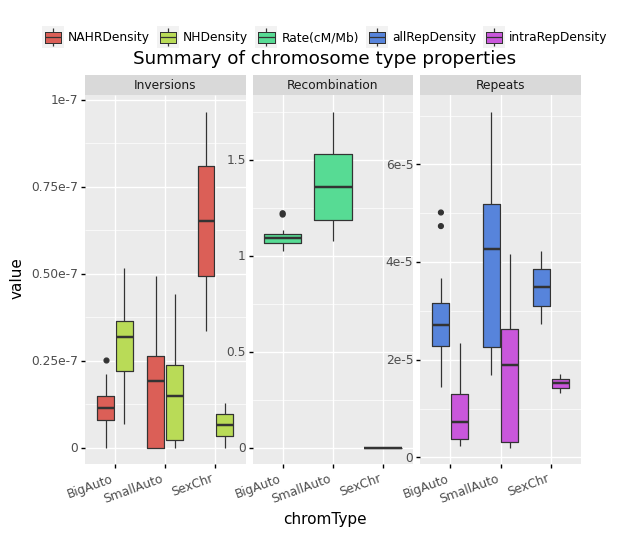

<ggplot: (8774829223045)>

In [10]:
# Boxplot of differences between chromosome types
# -------------------------------

invHist = byChrInfo.melt(id_vars=["Chromosome", "chromType"], value_vars= ["NAHRDensity", "NHDensity"])
invHist["Category"] = "Inversions"

repHist = byChrInfo.melt(id_vars=["Chromosome", "chromType"], value_vars= ["allRepDensity", "intraRepDensity"])
repHist["Category"] = "Repeats"

recHist = byChrInfo.melt(id_vars=["Chromosome", "chromType"], value_vars= ["Rate(cM/Mb)"])
recHist["Category"] = "Recombination"

Hist = pd.concat([invHist, repHist]).reset_index(drop=True)
Hist = pd.concat([Hist, recHist]).reset_index(drop=True)


# Make boxplot
(
    ggplot(Hist, aes(x = "chromType", fill = "variable", y = "value"))+
    geom_boxplot()+
    facet_wrap("Category", scales = "free")+
    scale_x_discrete(limits = ["BigAutosome", "SmallAutosome", "SexChr"], labels = ["BigAuto", "SmallAuto", "SexChr"])+
    # guides(guide_legend(nrow=1))+
    theme(legend_position= "top" , legend_title = element_blank() )+
    ggtitle("Summary of chromosome type properties")+
    theme( axis_text_x = element_text(angle = 20, hjust= 1))

     
    # ylab("Inversion/Mb")+xlab("Chromosome type") 

)



In [11]:
print(f"""Figure {figcounter}: Summary of differences between chromosomes. Small autosomes are chr1 to 12 and big autosomes chr13 to 22. SexChr are X and Y.""") 
figcounter+=1

Figure 1: Summary of differences between chromosomes. Small autosomes are chr1 to 12 and big autosomes chr13 to 22. SexChr are X and Y.


R[write to console]: corrplot 0.92 loaded



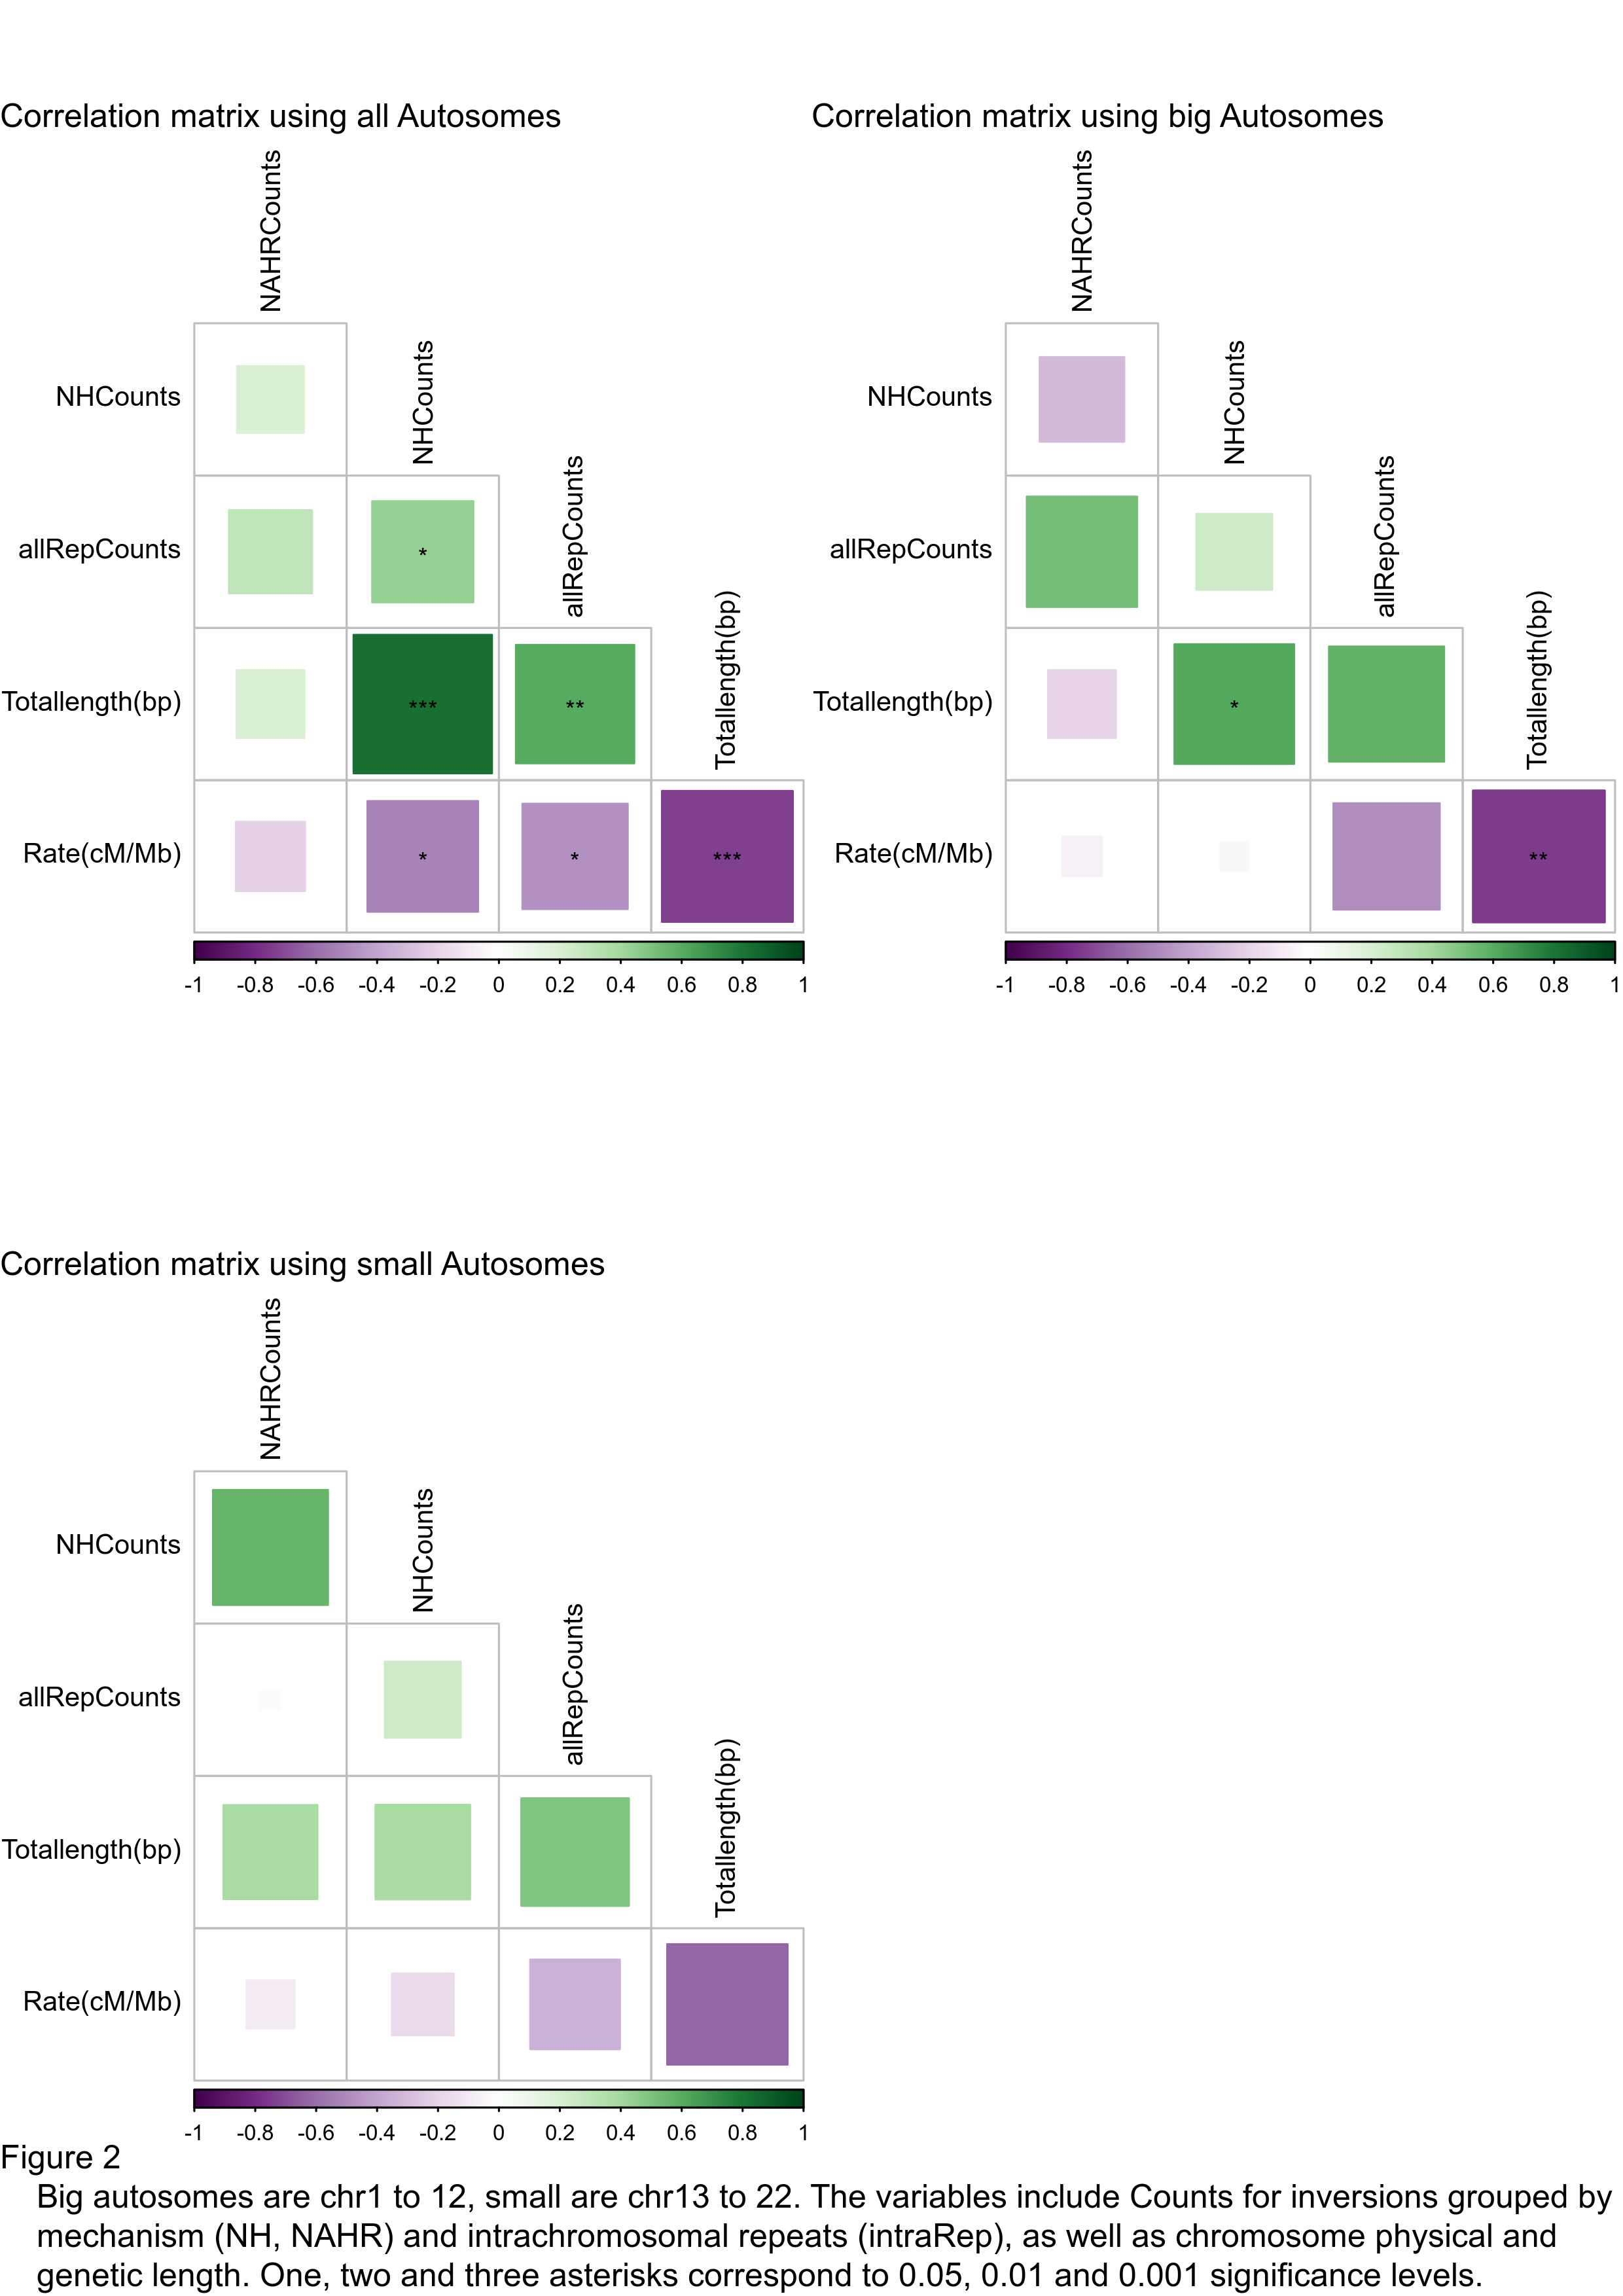

In [12]:
%%R -i Autosomes -i figcounter -h 3508 -w 2480 -r 300 -n

library("corrplot")

rownames(Autosomes) <- Autosomes$Chromosome

# All Autosomes
toPlot <- Autosomes[,c( "NAHRCounts", "NHCounts", "allRepCounts", "Totallength(bp)", "Rate(cM/Mb)")]
# # Big chromosomes
toPlotBig <- Autosomes[which(Autosomes$chromType == "BigAutosome" ),c( "NAHRCounts", "NHCounts", "allRepCounts", "Totallength(bp)", "Rate(cM/Mb)")]
# # # Small chromosomes
toPlotSmall <- Autosomes[which(Autosomes$chromType == "SmallAutosome" ),c( "NAHRCounts", "NHCounts", "allRepCounts", "Totallength(bp)", "Rate(cM/Mb)")]


# Figure
par(mfrow=c(2,2))
M <- list(all = toPlot, big = toPlotBig , small = toPlotSmall )

lapply(names(M), function(x){
    tab <- M[[x]]
    toPlotCorx = cor(as.matrix(tab))
    testResx = cor.mtest(tab, conf.level = 0.95)
    corrplot(toPlotCorx,  p.mat = testResx$p, sig.level = c(0.001, 0.01, 0.05), tl.col = "black", pch.cex = 0.9, insig = 'label_sig', type = "lower", method = "square", col = COL2('PRGn'), diag = FALSE)
    mtext(paste0("Correlation matrix using ",x," Autosomes"), side = 3, cex=1, adj = 0)

} )

mtext(paste0("Figure ",figcounter," 
    Big autosomes are chr1 to 12, small are chr13 to 22. The variables include Counts for inversions grouped by 
    mechanism (NH, NAHR) and intrachromosomal repeats (intraRep), as well as chromosome physical and 
    genetic length. One, two and three asterisks correspond to 0.05, 0.01 and 0.001 significance levels." 
    ), side = 1, adj = 0, cex = 1, line = 4)

In [13]:
# After summary
figcounter += 1

# Analysis of autosomes divided in sections


Chromosomes were divided into 5 sections, which is enough to observe high-recombination regions (Figure 3) while keeping a range of windows with 0 to 5 inversions of either type. Sadly, they are not small enough to differentiate low recombination regions. 

As shown in Figure 4, the quantity of NH inversions is directly proportional to window size and not influenced by the amount of repeats in the region, while the number of NAHR inversions in a window is proportional to how repetitive is the region, but not influenced by the window size, even when the quantity of repeats is. Supplementary Figure 11 shows that when looking at intrachromosomal repeats alone, the correlation is still significant. Larger windows are associated with lower recombination rates because window sizes are proportional to chromosome size and therefore keep the global tendency of having higher recombination rates in smaller chromosomes. Mean recombination rates of each window are not associated to a higher incidence of either inversion type at this scale.  

These results suggest that the position of polymorphic inversions in the genome would be determined by their origin rather than the influence of surrounding recombination rates in their later failure or success. However, this may or may not be true at higher resolutions, which will be analyzed in the next report (Location Patterns 2). 

In [14]:
# CONTENT: Loop to Make chromosome fragments from recombination rate data
# -----------------------------------------

fragCount = 5

allChromRegions = DataFrame()
for ch in recRate.Chromosome.unique(): 
    minirate = recRate[(recRate.Chromosome == ch) & (recRate.Position >0) ]

    win = round(max(minirate.Position)/fragCount)
    positions = range(0,max(minirate.Position), win) 
    means = [ minirate[(minirate.Position >= r) & (minirate.Position < r+win)].Rate.mean() for r in positions ]

    averages = DataFrame({"Positions" : positions, "MeanRates" : means, "Positions_end": range(win, max(minirate.Position) + win, win), "Chromosome":ch})
    allChromRegions = allChromRegions.append(averages)

    allChromRegions.Chromosome = pd.Categorical(allChromRegions.Chromosome, categories = chrNames)


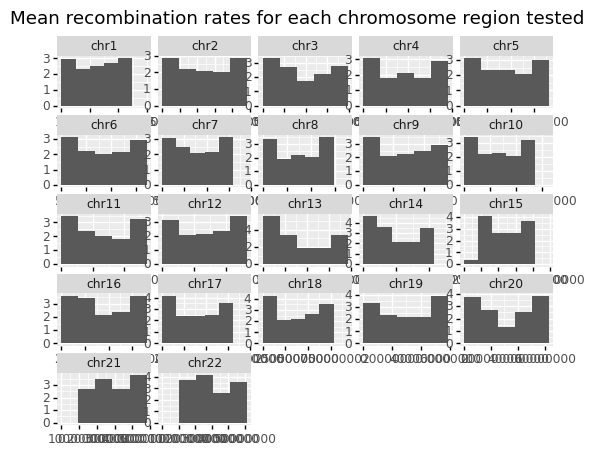

<ggplot: (8774835593388)>

In [15]:
# PLOT: Regions to test
# ----------------------------------------

(ggplot(allChromRegions)+
    geom_rect(aes(xmin = "Positions", xmax = "Positions_end",   ymax = "MeanRates", ymin = 0))+
    facet_wrap("Chromosome", scales = "free")+
    ggtitle("Mean recombination rates for each chromosome region tested")
)



In [16]:
print(f"""Figure {figcounter}: {fragCount} bins per chromosome are small enough to differenciate high recombination regions (near telomeres), but not so clearly low recombination regions, which should be near centromeres.""" )

figcounter+=1

Figure 3: 5 bins per chromosome are small enough to differenciate high recombination regions (near telomeres), but not so clearly low recombination regions, which should be near centromeres.


In [17]:
# CONTENT: calculate the incidences for each segment
# ------------------------------------------------

# Number of invs
inv["CenterPos"] = inv["BP1_1.1"] + ((inv["BP2_2.1"]- inv["BP1_1.1"] +1 )/2) -1 # now it is 0-based
inv["CenterBP1"] = inv["BP1_1.1"] + ((inv["BP1_2.1"]- inv["BP1_1.1"] +1 )/2) -1 # now it is 0-based
inv["CenterBP2"] = inv["BP2_1.1"] + ((inv["BP2_2.1"]- inv["BP2_1.1"] +1 )/2) -1 # now it is 0-based

allChromRegions["invCenters"] = [len(inv[(inv.Chr == row["Chromosome"]) & (inv.CenterPos >= row["Positions"]) & (inv.CenterPos < row["Positions_end"])].index) for index, row in allChromRegions.iterrows()]

allChromRegions["invBreakpoints"] = [
    len(inv[(inv.Chr == row["Chromosome"]) & (inv.CenterBP1 >= row["Positions"]) & (inv.CenterBP1 < row["Positions_end"])].index) +
    len(inv[(inv.Chr == row["Chromosome"]) & (inv.CenterBP2 >= row["Positions"]) & (inv.CenterBP2 < row["Positions_end"])].index) 
    for index, row in allChromRegions.iterrows()
    ]

# Number of invs of each type
## NH
allChromRegions["NHCenters"] = [
    len(inv[(inv.Chr == row["Chromosome"]) & (inv.CenterPos >= row["Positions"]) & (inv.CenterPos < row["Positions_end"]) & (inv.OriginFixed == "NH" )].index) 
    for index, row in allChromRegions.iterrows()
    ]

allChromRegions["NHBreakpoints"] = [
    len(inv[(inv.Chr == row["Chromosome"]) & (inv.CenterBP1 >= row["Positions"]) & (inv.CenterBP1 < row["Positions_end"]) & (inv.OriginFixed == "NH" )].index) +
    len(inv[(inv.Chr == row["Chromosome"]) & (inv.CenterBP2 >= row["Positions"]) & (inv.CenterBP2 < row["Positions_end"]) & (inv.OriginFixed == "NH" )].index) 
    for index, row in allChromRegions.iterrows()
    ]

## NAHR
allChromRegions["NAHRCenters"] = [
    len(inv[(inv.Chr == row["Chromosome"]) & (inv.CenterPos >= row["Positions"]) & (inv.CenterPos < row["Positions_end"]) & (inv.OriginFixed == "NAHR" )].index) 
    for index, row in allChromRegions.iterrows()
    ]

allChromRegions["NAHRBreakpoints"] = [
    len(inv[(inv.Chr == row["Chromosome"]) & (inv.CenterBP1 >= row["Positions"]) & (inv.CenterBP1 < row["Positions_end"]) & (inv.OriginFixed == "NAHR" )].index) +
    len(inv[(inv.Chr == row["Chromosome"]) & (inv.CenterBP2 >= row["Positions"]) & (inv.CenterBP2 < row["Positions_end"]) & (inv.OriginFixed == "NAHR" )].index) 
    for index, row in allChromRegions.iterrows()
    ]

# Count repeats and intrachromosomal repeats
segDups.chromCenter = segDups["chromStart"] + ((segDups["chromEnd"]- segDups["chromStart"] +1 )/2) -1
segDups.otherCenter = segDups["otherStart"] + ((segDups["otherEnd"]- segDups["otherStart"] +1 )/2) -1
## All repeats
allChromRegions["allRepCounts"] =[
    len(segDups[(segDups.chrom == row["Chromosome"]) & (segDups.chromCenter >= row["Positions"]) & (segDups.chromCenter < row["Positions_end"])].index) + 
    len(segDups[(segDups.otherChrom == row["Chromosome"]) & (segDups.otherCenter >= row["Positions"]) & (segDups.otherCenter < row["Positions_end"])].index)
    for index, row in allChromRegions.iterrows()
    ]
## Intrachromosomal repeats, each copy counted different because they can be in different regions 
allChromRegions["intraRepCounts"] = [
    len(segDups[(segDups.chrom == segDups.otherChrom) & (segDups.chrom == row["Chromosome"]) & (segDups.chromCenter >= row["Positions"]) & (segDups.chromCenter < row["Positions_end"])].index) + 
    len(segDups[(segDups.chrom == segDups.otherChrom) & (segDups.otherChrom == row["Chromosome"]) & (segDups.otherCenter >= row["Positions"]) & (segDups.otherCenter < row["Positions_end"])].index)
    for index, row in allChromRegions.iterrows()
    ] 

# Add segment size
allChromRegions["Length(bp)"] = allChromRegions.Positions_end - allChromRegions.Positions

# In this dataset we only have autosomes

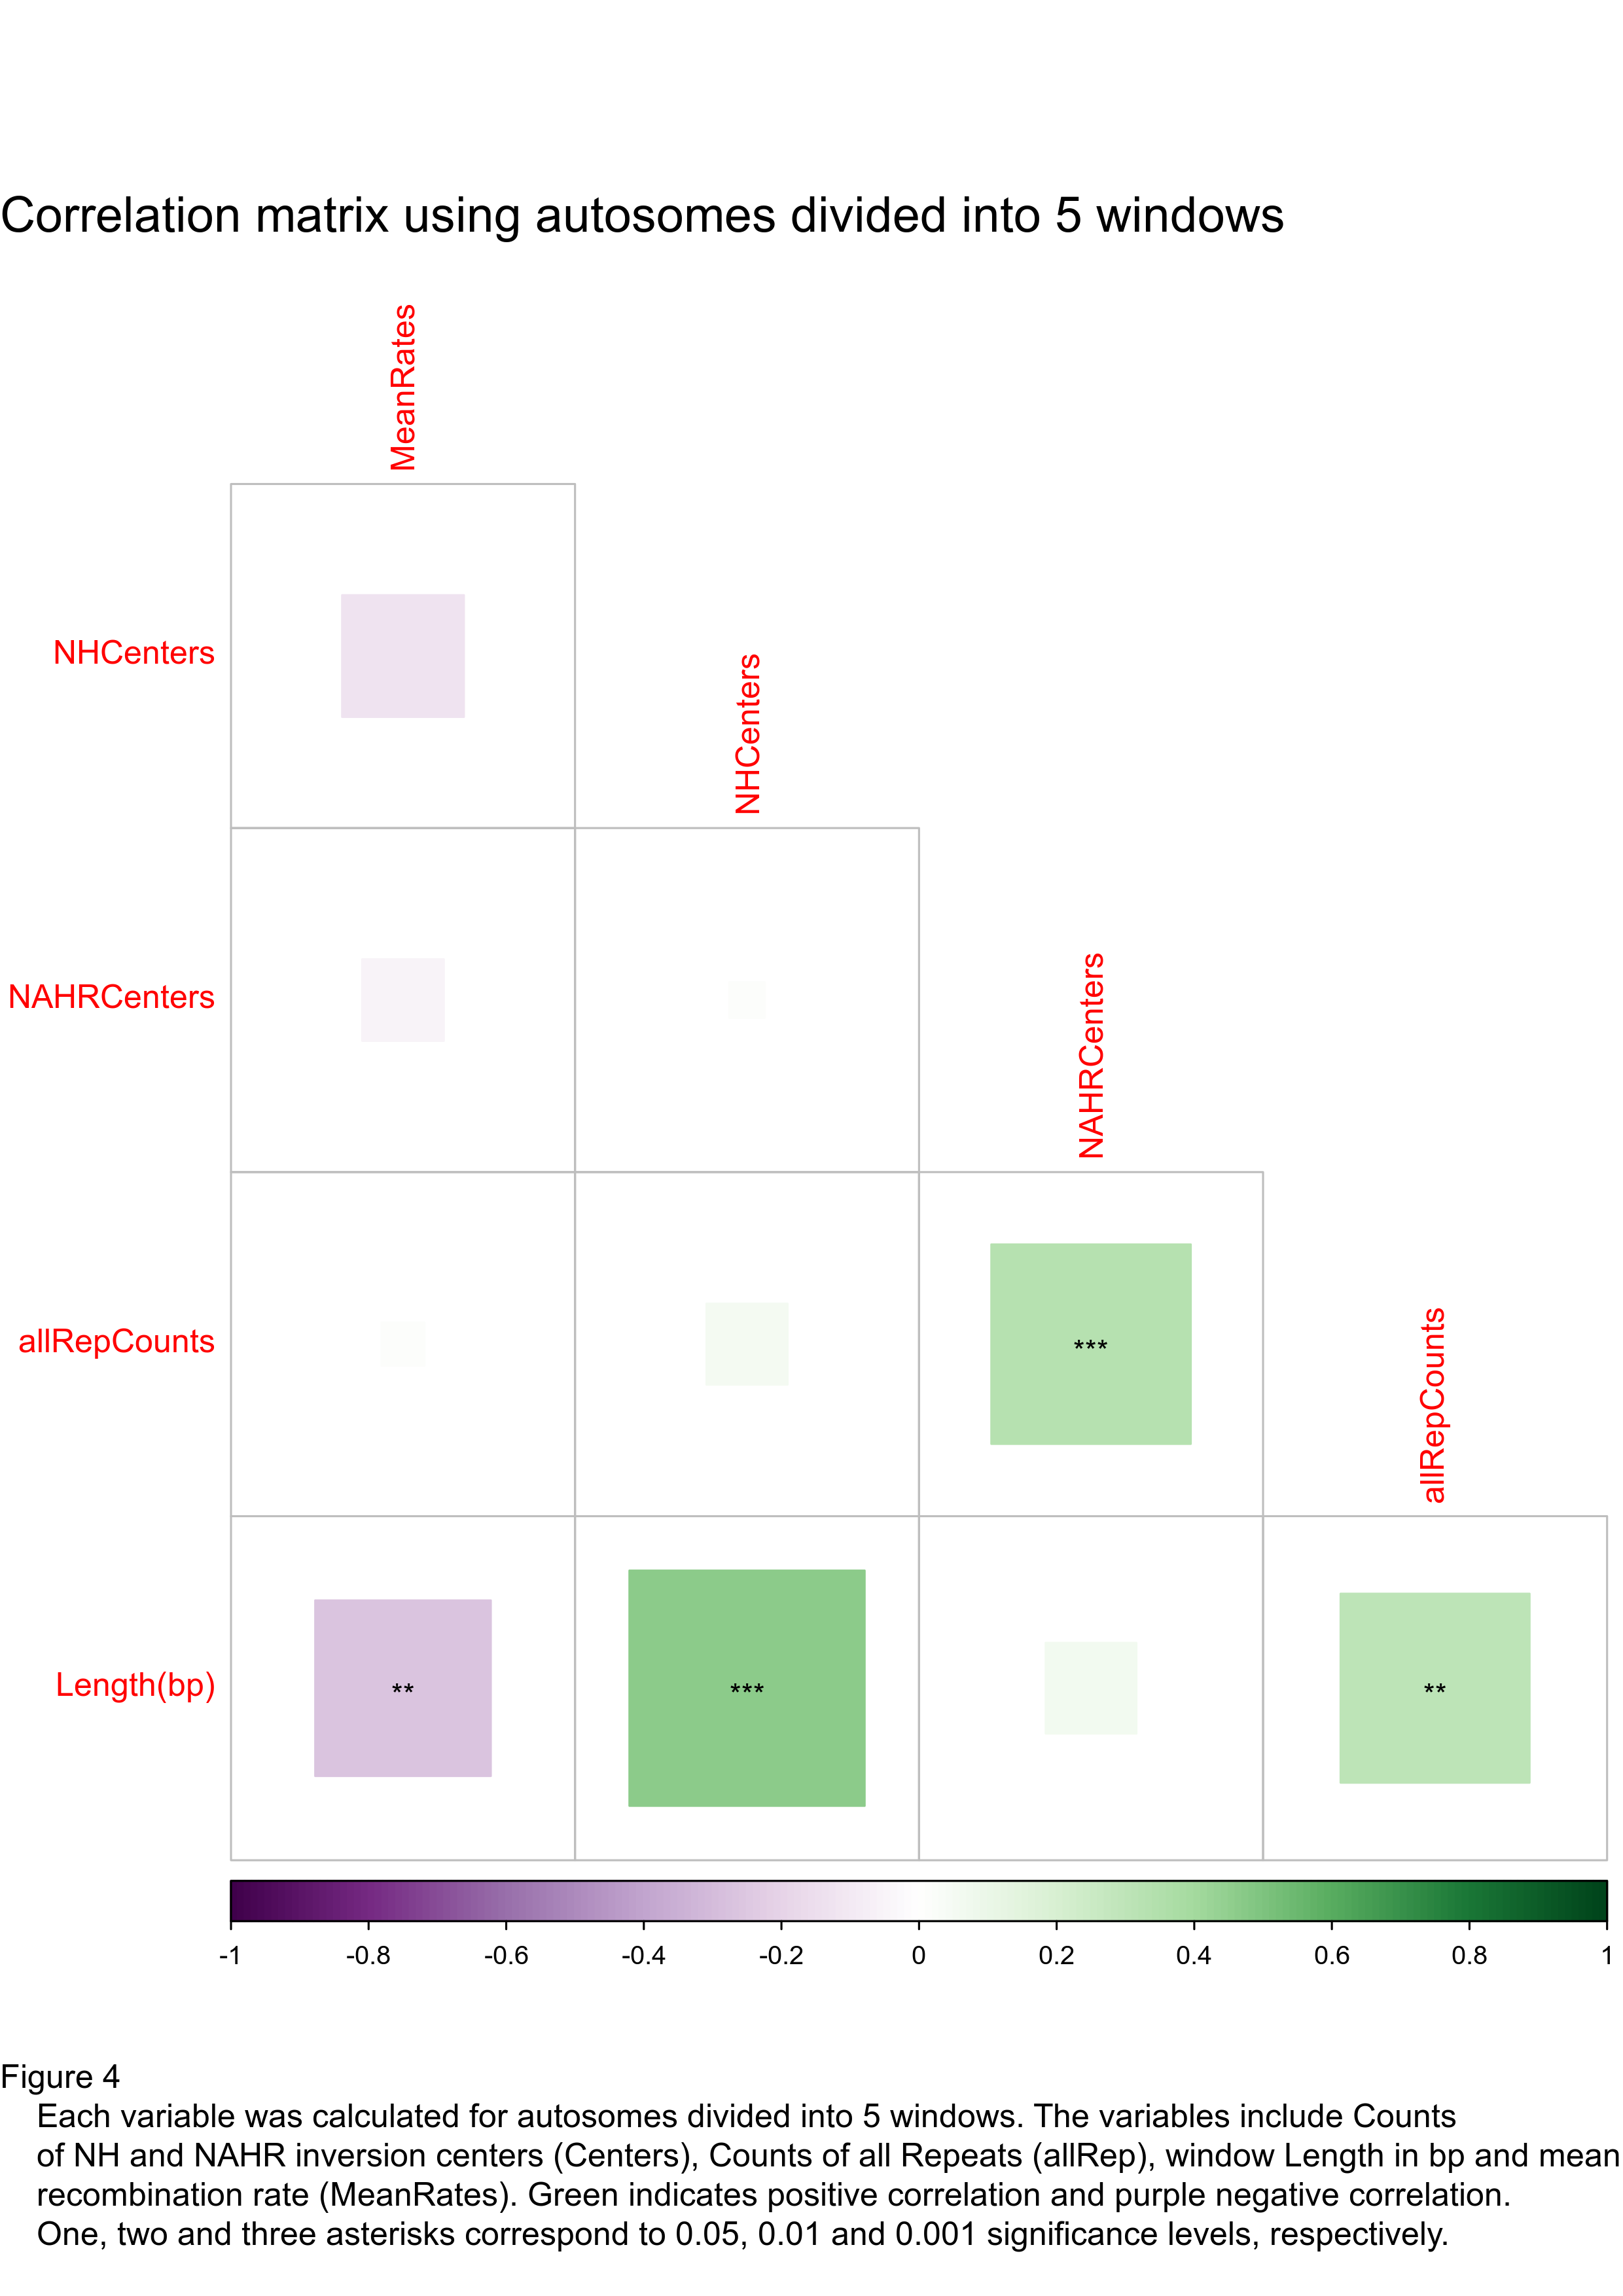

In [18]:
%%R -i allChromRegions -i figcounter -i fragCount -h 3508 -w 2480 -r 300 -n

library("corrplot")

rownames(allChromRegions) <- paste0(allChromRegions$Chromosome, allChromRegions$Positions)

toPlot <- allChromRegions[which(allChromRegions$MeanRates > 0),c("MeanRates", "NHCenters", "NAHRCenters", "allRepCounts", "Length(bp)")]

toPlotCor = cor(as.matrix(toPlot))
testRes = cor.mtest(toPlot, conf.level = 0.95)

corrplot(toPlotCor, p.mat = testRes$p, sig.level = c(0.001, 0.01, 0.05), pch.cex = 0.9, insig = 'label_sig', type = "lower", method = "square", col = COL2('PRGn'), diag = FALSE)
mtext(paste0("Correlation matrix using autosomes divided into ",fragCount," windows"), side = 3, cex=1.5, adj = 0, line = -2)
mtext(paste0("Figure ",figcounter," 
    Each variable was calculated for autosomes divided into ",fragCount," windows. The variables include Counts 
    of NH and NAHR inversion centers (Centers), Counts of all Repeats (allRep), window Length in bp and mean 
    recombination rate (MeanRates). Green indicates positive correlation and purple negative correlation. 
    One, two and three asterisks correspond to 0.05, 0.01 and 0.001 significance levels, respectively." 
    ), side = 1, adj = 0, cex = 1, line = 3)

In [19]:
# After simple correlation, autosomes in sections
figcounter += 1

# Ideas to complete this analysis

- [ ] Histogram of inversion density for each chromosome
- [ ] Test other repeat categories from GenomicSuperDup
- [ ] Heterogeneity test for distributions
- [ ] Study chromosome X (and Y?)
- [ ] Simulate/anallitically demonstrate the expected location along chromosome arm, depending on the probability of having two breaks at a certain distance.
- [ ] Multiple linear regression (is this possible with only one variable having positive correlation?)
<!-- - [x]  -->

# Supplementary figures


## Differences between chromosomes in the distribution of variables

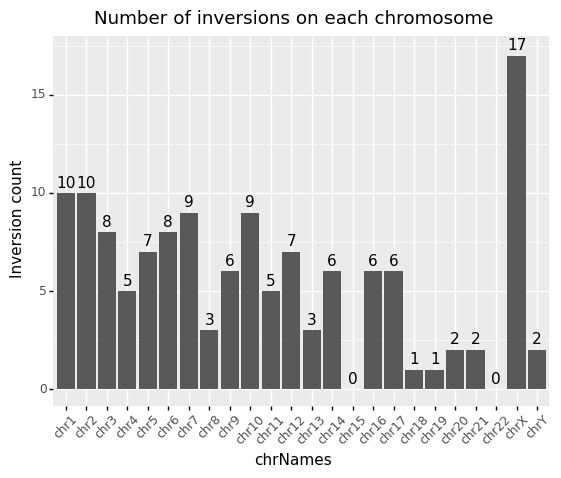

<ggplot: (8774829209793)>

In [20]:
# PLOT:  Distribution of inversions by chromosome overview 
# -------------------------------

# Make barplot values 
hist = DataFrame(inv.Chr.value_counts(dropna=False))

# Set chromosome names list
a = np.char.array(list(map(str,range(1,23)))+["X", "Y"])
b = np.char.array(["chr"] * 24)
chrNames = b+a 

# Merge both
chrNamesDF = DataFrame({"chrNames" : chrNames } )

hist = hist.merge(chrNamesDF, left_index=True, right_on = "chrNames", how = "outer")
hist["Chr"] = hist["Chr"].replace(np.NaN, 0)
hist["Chr"]= hist["Chr"].astype(int)

# Make plot 
(
    ggplot(hist)+
        geom_bar(aes(x = "chrNames", y = "Chr"), stat="identity")+
        geom_text(aes(label= "Chr", y = "Chr", x = "chrNames"),        nudge_y=0.125,     va='bottom' )+
        scale_x_discrete(limits = chrNames)+
        theme( axis_text_x = element_text(angle = 45, vjust = 1, hjust=2))+
        ylab("Inversion count")+
        ggtitle("Number of inversions on each chromosome")

)




In [21]:
# After histogram of distribution of inversions by chromosome
print(f"Figure {figcounter}: Number of inversions for each chromosome in the dataset.")
figcounter+=1


Figure 5: Number of inversions for each chromosome in the dataset.


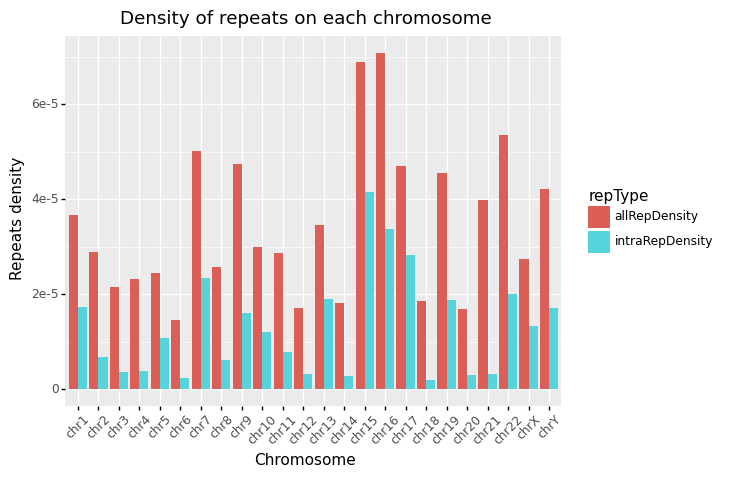

<ggplot: (8774838995950)>

In [22]:
# PLOT:  Distribution of repeats by chromosome overview 
# -------------------------------

repeatsHist = byChrInfo.melt(id_vars = ["Chromosome", "chromType"], value_vars = ["allRepDensity", "intraRepDensity"], var_name = "repType", value_name = "repDensity")

(
    ggplot(repeatsHist, aes(x = "Chromosome", y = "repDensity", fill = "repType"))+
        geom_bar( stat="identity", position = "dodge")+
        # geom_text(aes(label= "repCDensity"),  angle = 90,    position = position_dodge(width = 0.9) , size = 8 )+
        scale_x_discrete(limits = chrNames)+
        theme( axis_text_x = element_text(angle = 45, vjust = 1, hjust=2))+
        ylab("Repeats density")+
        ggtitle("Density of repeats on each chromosome")

)




In [23]:
# After histogram of distribution of repeats by chromosome
print(f"Figure {figcounter}: Desnity of repeats for each chromosome in the dataset.")
figcounter+=1


Figure 6: Desnity of repeats for each chromosome in the dataset.


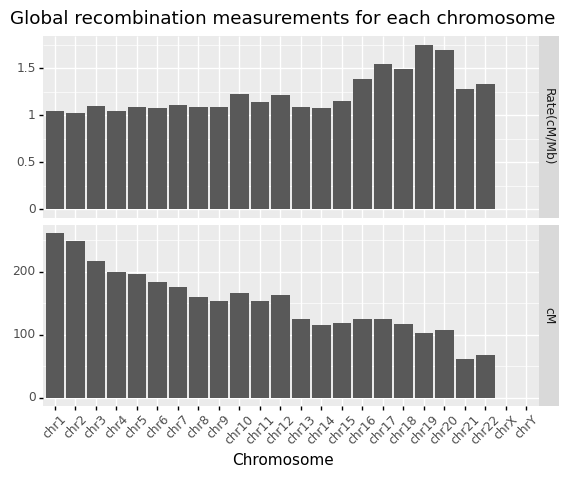

<ggplot: (8774829202122)>

In [24]:
recombHist = byChrInfo.melt(id_vars = ["Chromosome", "chromType"], value_vars = ["Rate(cM/Mb)", "cM"], var_name = "recType", value_name = "recCounts")


(
    ggplot(recombHist)+
    geom_bar(aes(x = "Chromosome", y = "recCounts"), stat= "identity")+
     scale_x_discrete(limits = chrNames)+
        theme( axis_text_x = element_text(angle = 45, vjust = 1, hjust=2))+
        ggtitle("Global recombination measurements for each chromosome")+
        ylab("")+
        facet_grid("recType ~ .", scales = "free")
)

In [25]:
# After histogram of distribution of repeats by chromosome
print(f"Figure {figcounter}: Recombination rate and genetic length for each chromosome in the dataset.")
figcounter+=1


Figure 7: Recombination rate and genetic length for each chromosome in the dataset.


## Simple correlation matrices (just values)

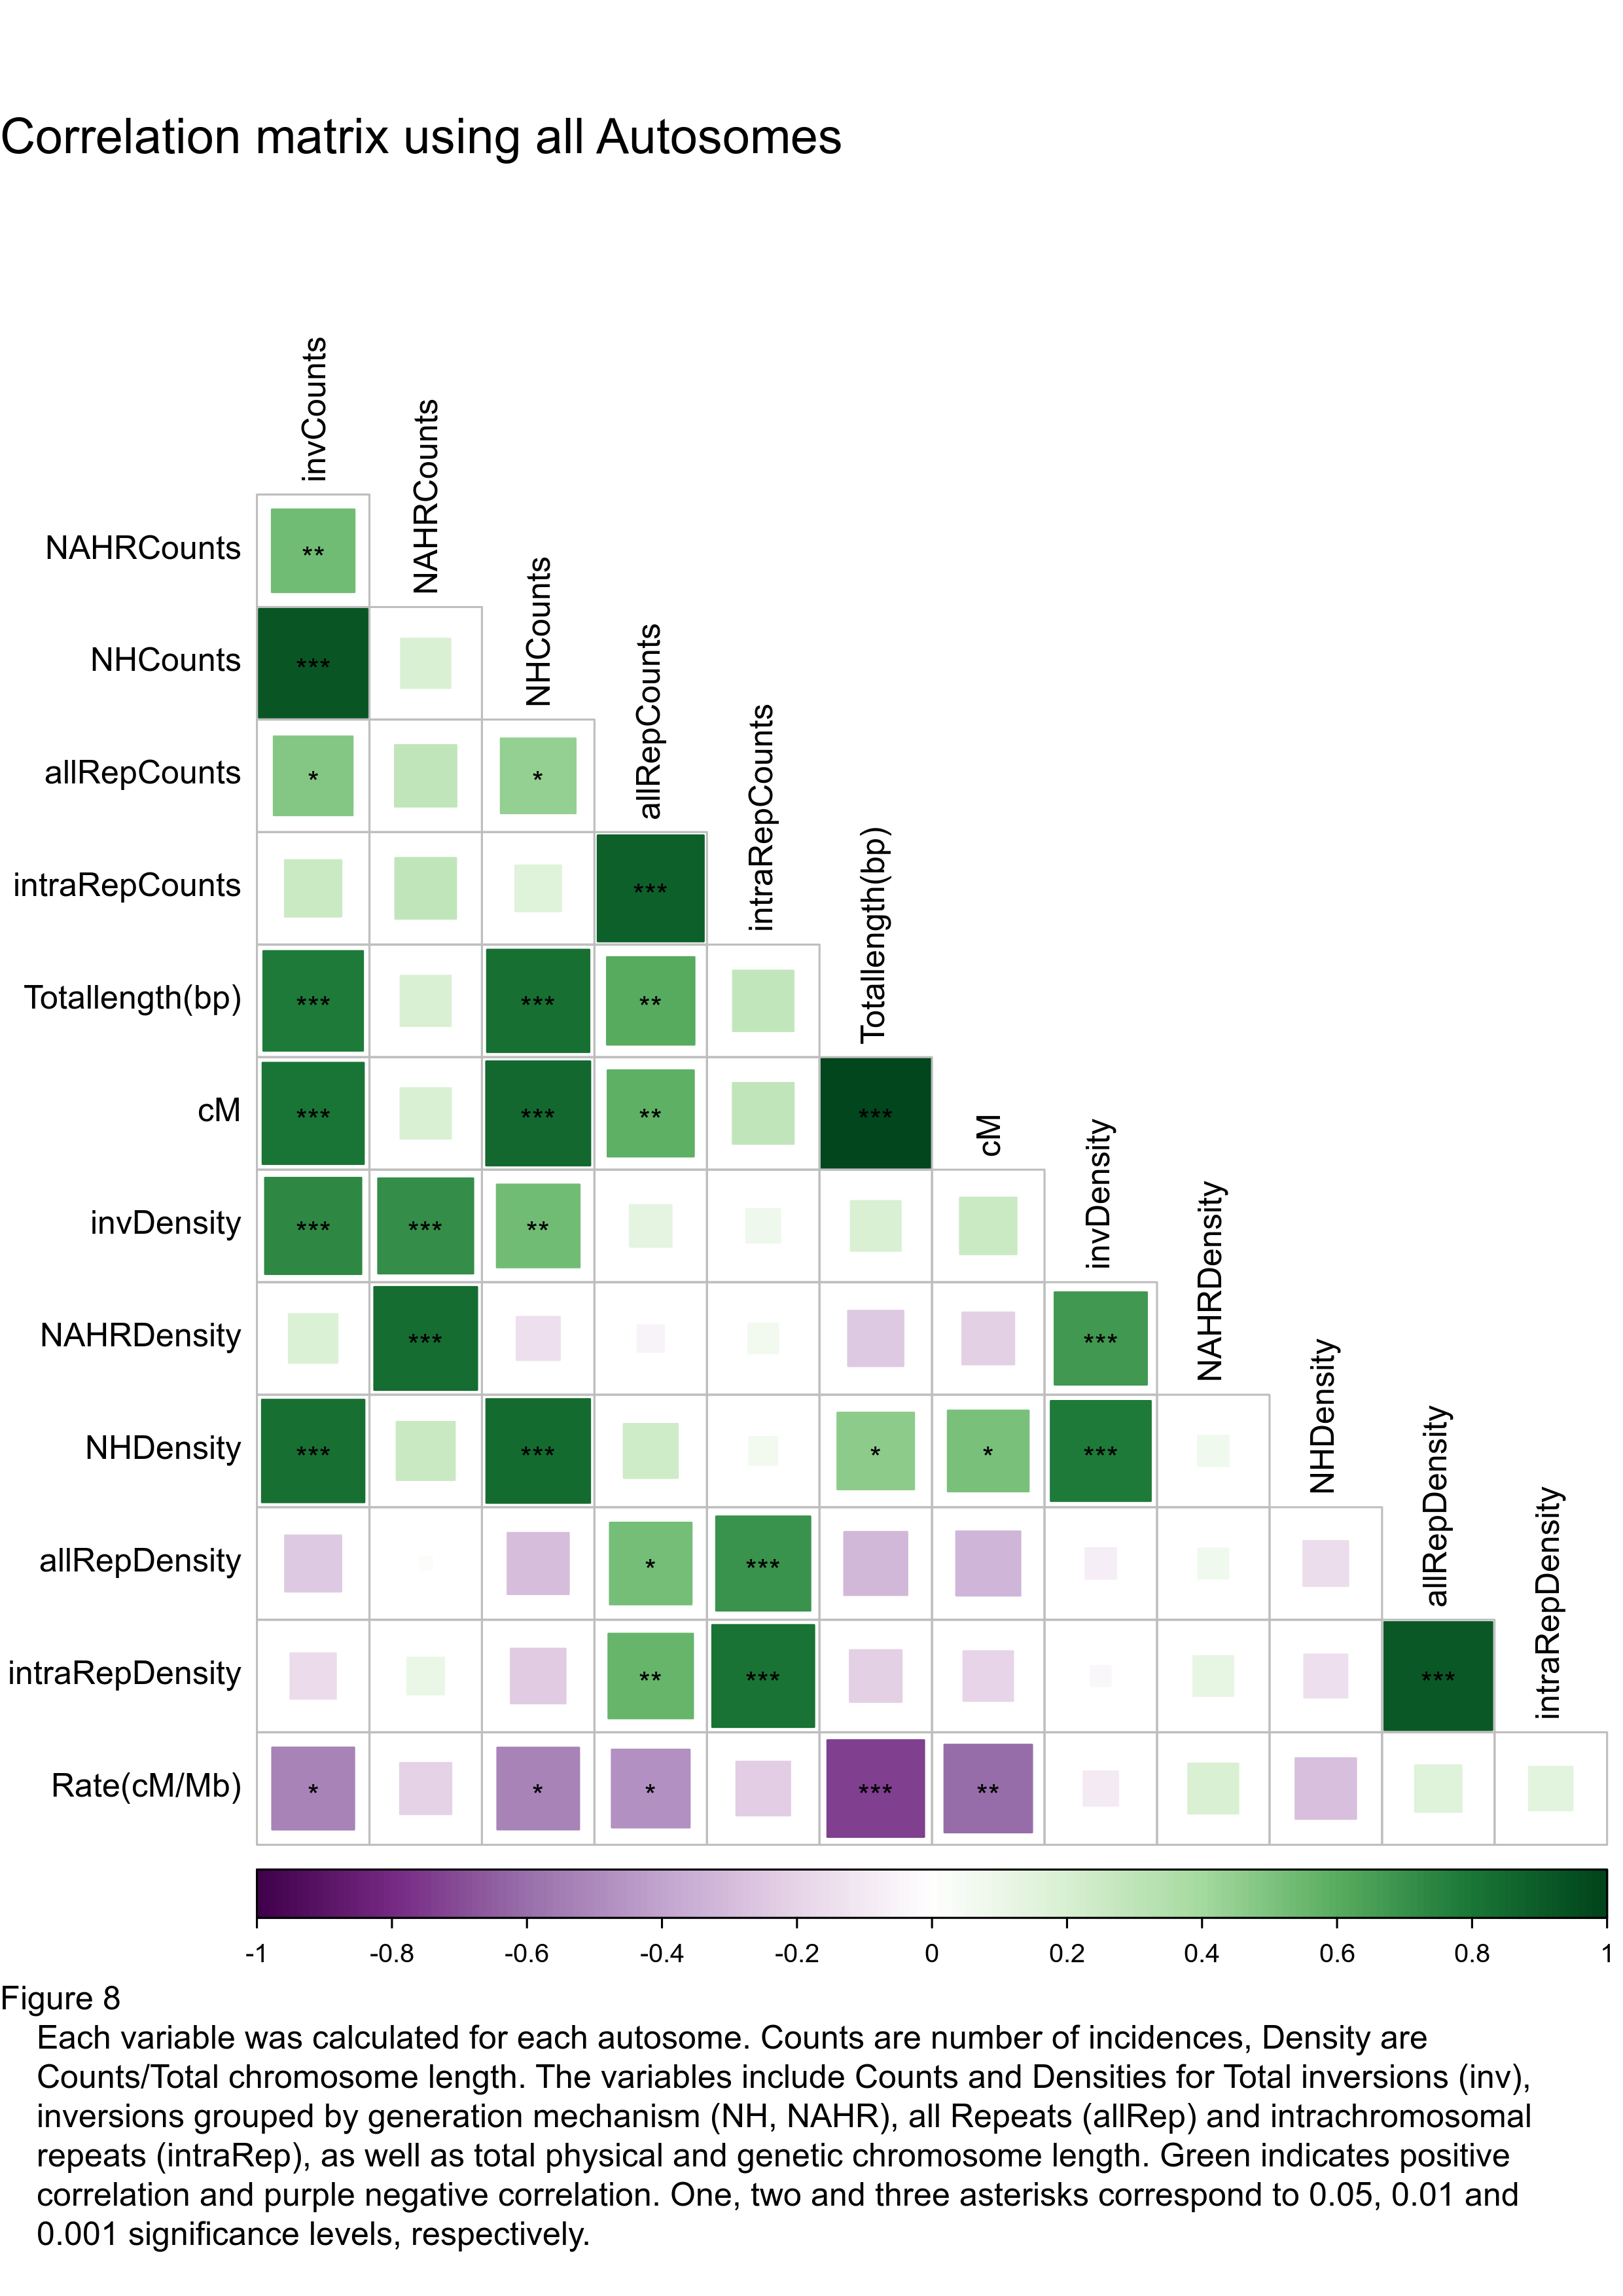

In [26]:
%%R -i Autosomes -i figcounter -h 3508 -w 2480 -r 300 -n

library("corrplot")

rownames(Autosomes) <- Autosomes$Chromosome

toPlot <- Autosomes[,c(3:ncol(Autosomes))]

toPlotCor = cor(as.matrix(toPlot))
testRes = cor.mtest(toPlot, conf.level = 0.95)

corrplot(toPlotCor,  p.mat = testRes$p, sig.level = c(0.001, 0.01, 0.05), tl.col = "black", pch.cex = 0.9, insig = 'label_sig', type = "lower", method = "square", col = COL2('PRGn'), diag = FALSE)
mtext("Correlation matrix using all Autosomes", side = 3, cex=1.5, adj = 0)
mtext(paste0("Figure ",figcounter," 
    Each variable was calculated for each autosome. Counts are number of incidences, Density are 
    Counts/Total chromosome length. The variables include Counts and Densities for Total inversions (inv), 
    inversions grouped by generation mechanism (NH, NAHR), all Repeats (allRep) and intrachromosomal 
    repeats (intraRep), as well as total physical and genetic chromosome length. Green indicates positive 
    correlation and purple negative correlation. One, two and three asterisks correspond to 0.05, 0.01 and
    0.001 significance levels, respectively." 
    ), side = 1, adj = 0, cex = 1, line = 3)

In [27]:
# After simple correlation, all autosomes
figcounter += 1

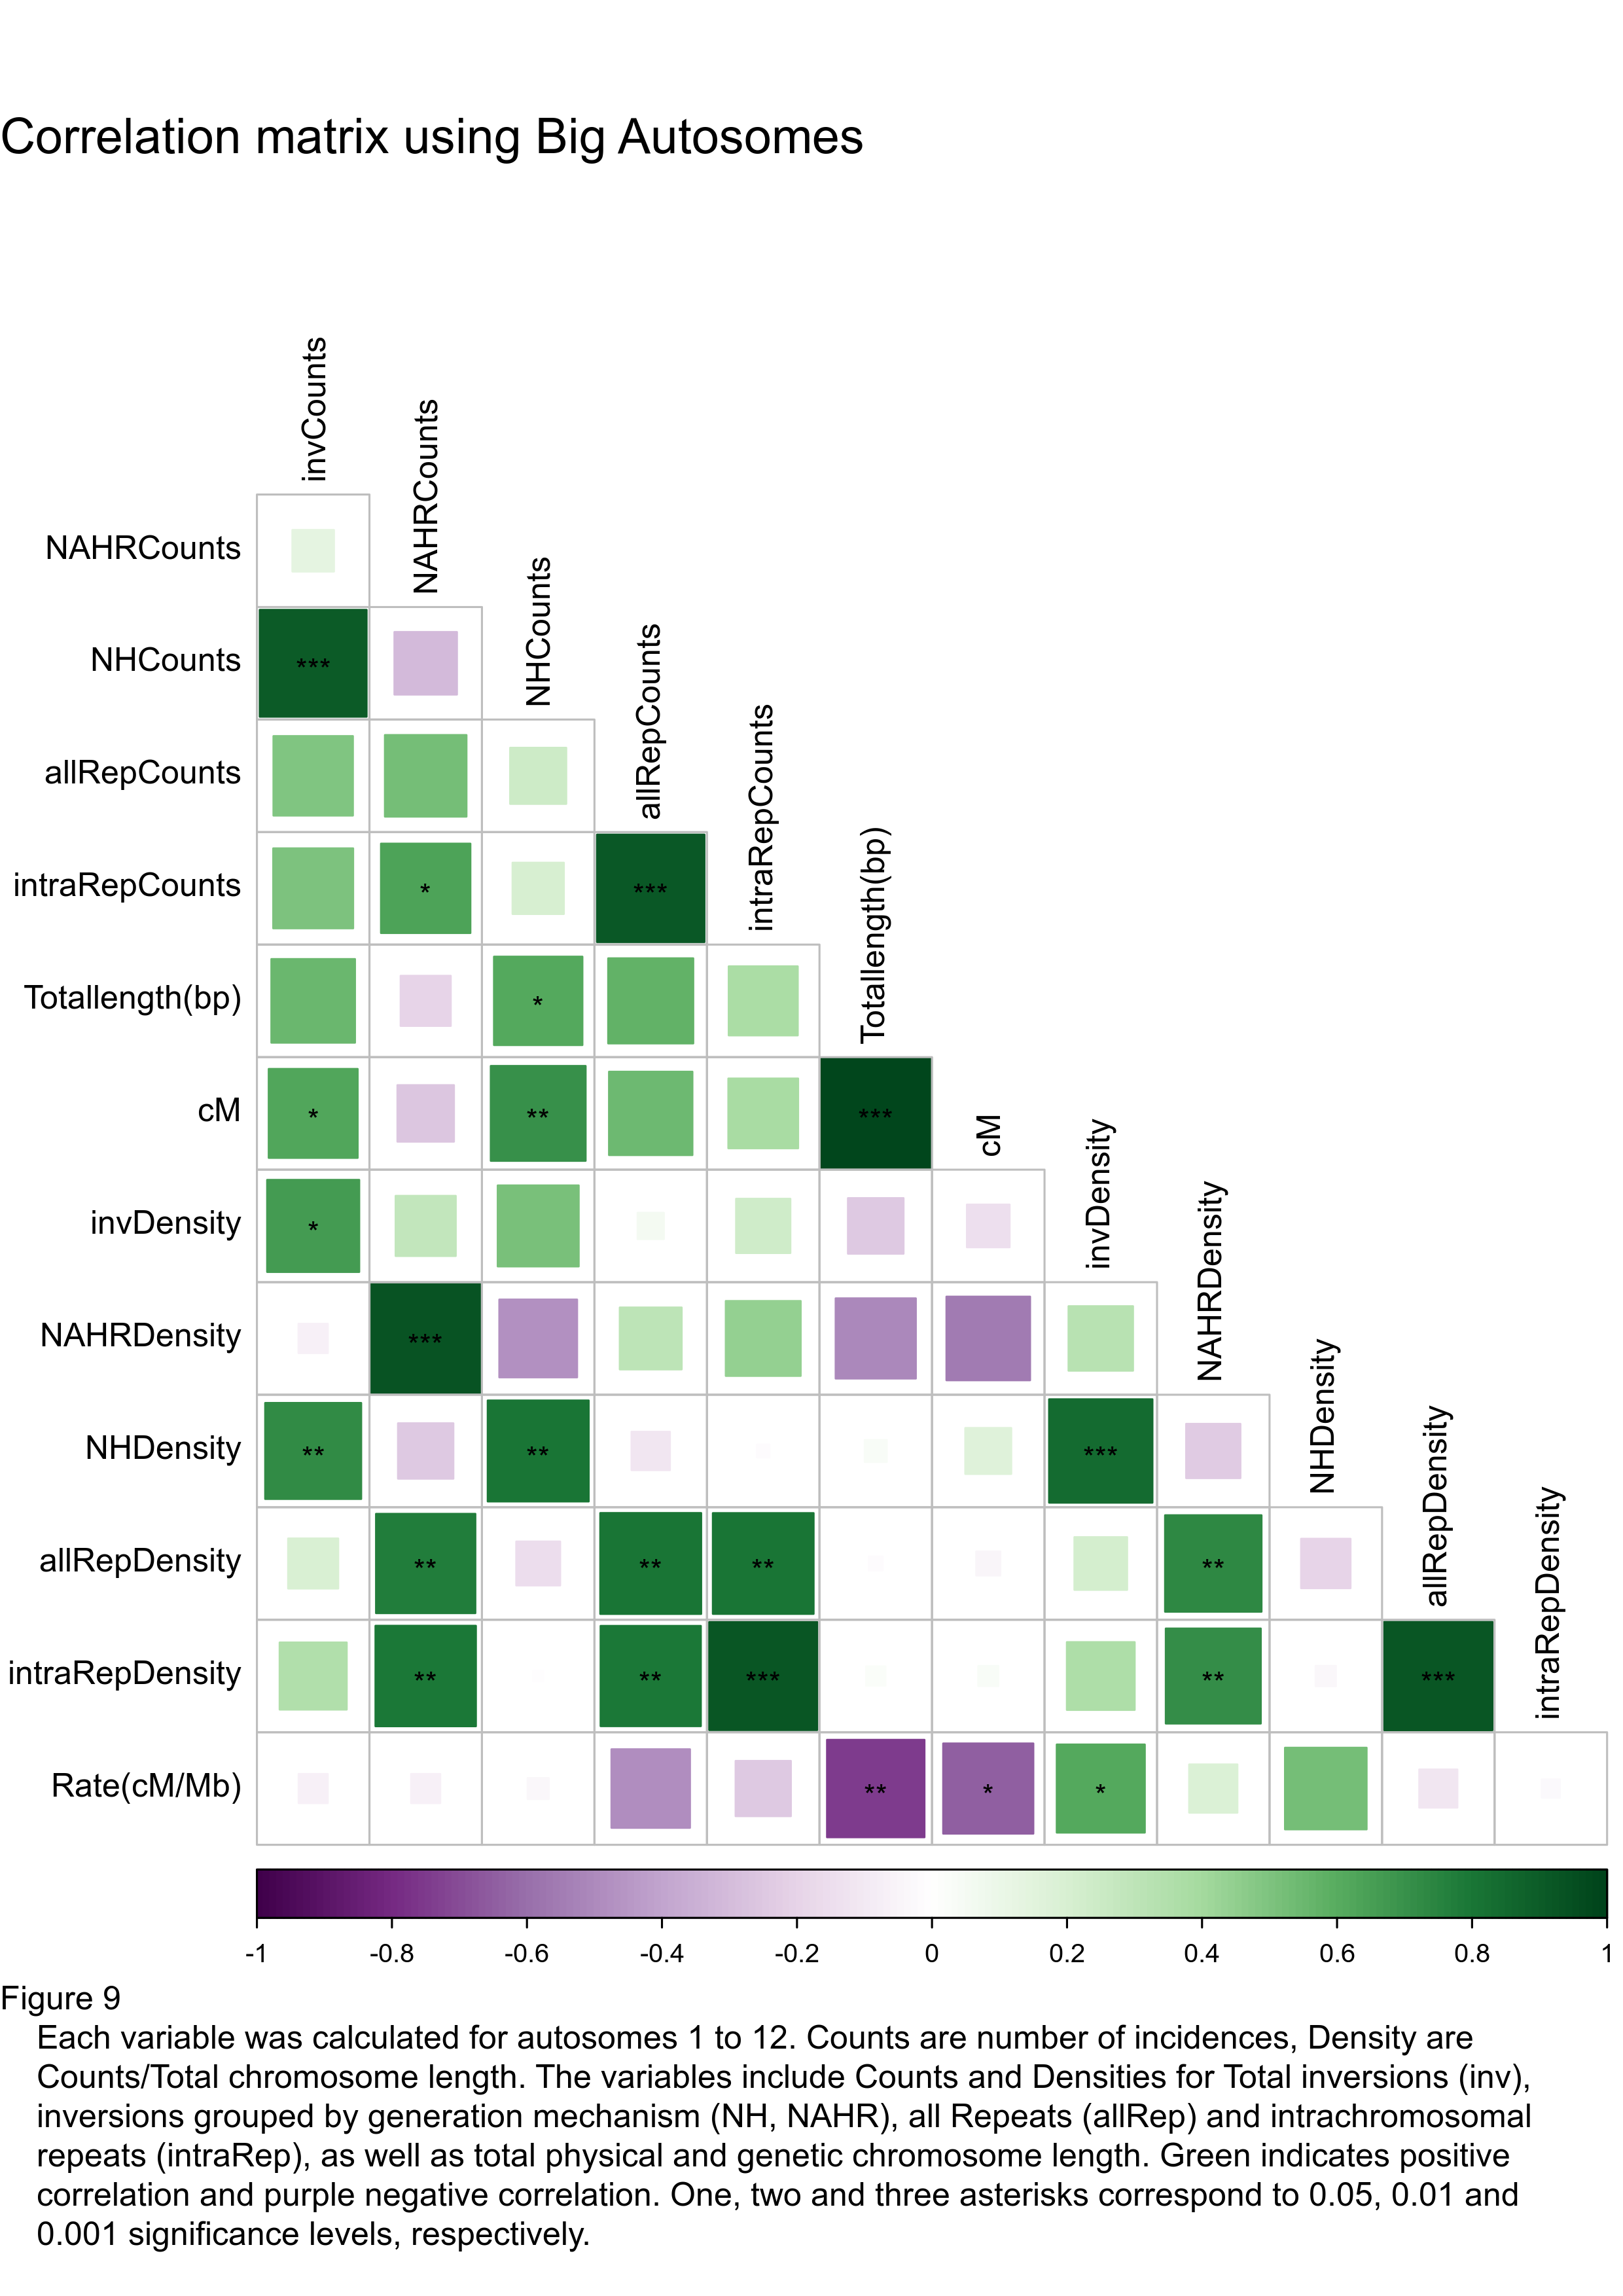

In [28]:
%%R -i Autosomes -i figcounter -h 3508 -w 2480 -r 300 -n

library("corrplot")

rownames(Autosomes) <- Autosomes$Chromosome

toPlot <- Autosomes[which(Autosomes$chromType == "BigAutosome" ),c(3:ncol(Autosomes))]

toPlotCor = cor(as.matrix(toPlot))
testRes = cor.mtest(toPlot, conf.level = 0.95)

# corrplot(toPlotCor, p.mat = testRes$p, sig.level = c(0.001, 0.01, 0.05), pch.cex = 0.9, insig = 'label_sig', type = "lower", method = "square",col = COL2('PRGn'), diag = FALSE)
corrplot(toPlotCor,  p.mat = testRes$p, sig.level = c(0.001, 0.01, 0.05), tl.col = "black", pch.cex = 0.9, insig = 'label_sig', type = "lower", method = "square", col = COL2('PRGn'), diag = FALSE)
mtext("Correlation matrix using Big Autosomes", side = 3, cex=1.5, adj = 0)
mtext(paste0("Figure ",figcounter," 
    Each variable was calculated for autosomes 1 to 12. Counts are number of incidences, Density are 
    Counts/Total chromosome length. The variables include Counts and Densities for Total inversions (inv), 
    inversions grouped by generation mechanism (NH, NAHR), all Repeats (allRep) and intrachromosomal 
    repeats (intraRep), as well as total physical and genetic chromosome length. Green indicates positive 
    correlation and purple negative correlation. One, two and three asterisks correspond to 0.05, 0.01 and
    0.001 significance levels, respectively." 
    ), side = 1, adj = 0, cex = 1, line = 3)

In [29]:
# After simple correlation, big autosomes
figcounter += 1

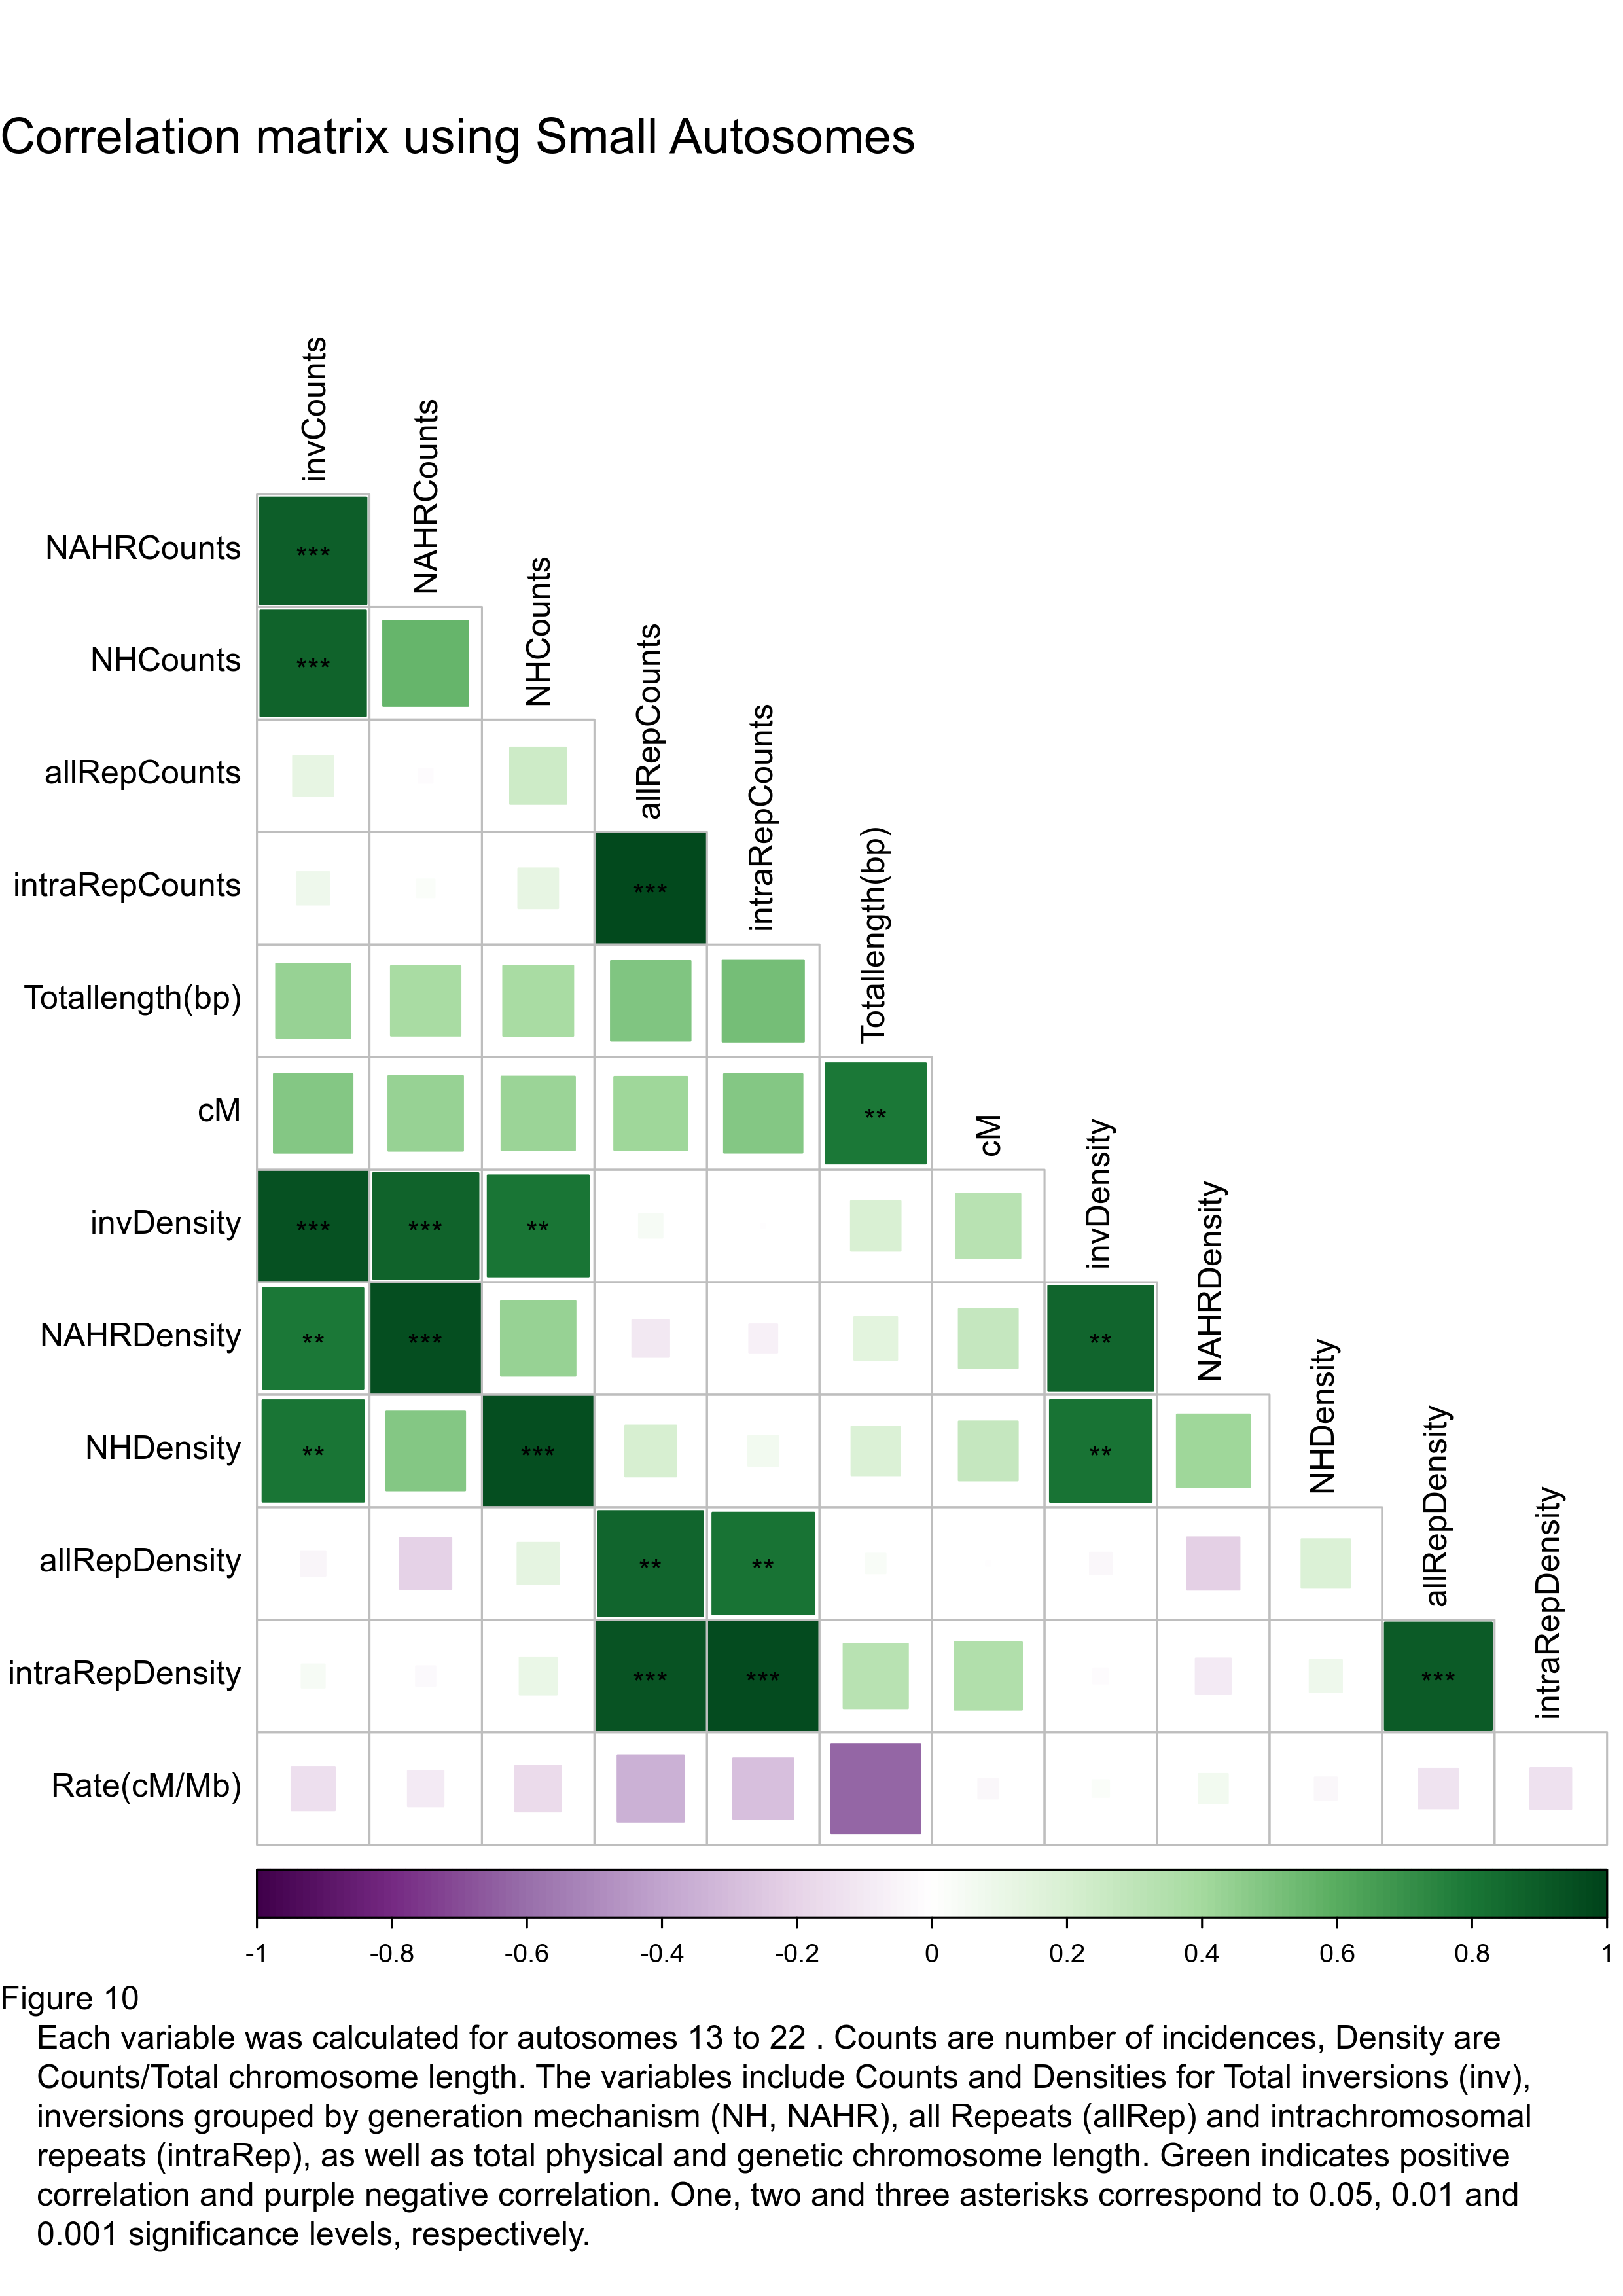

In [30]:
%%R -i Autosomes -i figcounter -h 3508 -w 2480 -r 300 -n

library("corrplot")

rownames(Autosomes) <- Autosomes$Chromosome

toPlot <- Autosomes[which(Autosomes$chromType == "SmallAutosome" ),c(3:ncol(Autosomes))]

toPlotCor = cor(as.matrix(toPlot))
testRes = cor.mtest(toPlot, conf.level = 0.95)

# corrplot(toPlotCor, p.mat = testRes$p, sig.level = c(0.001, 0.01, 0.05), pch.cex = 0.9, insig = 'label_sig', type = "lower", method = "square",col = COL2('PRGn'), diag = FALSE)
corrplot(toPlotCor,  p.mat = testRes$p, sig.level = c(0.001, 0.01, 0.05), tl.col = "black", pch.cex = 0.9, insig = 'label_sig', type = "lower", method = "square", col = COL2('PRGn'), diag = FALSE)
mtext("Correlation matrix using Small Autosomes", side = 3, cex=1.5, adj = 0)
mtext(paste0("Figure ",figcounter," 
    Each variable was calculated for autosomes 13 to 22 . Counts are number of incidences, Density are 
    Counts/Total chromosome length. The variables include Counts and Densities for Total inversions (inv), 
    inversions grouped by generation mechanism (NH, NAHR), all Repeats (allRep) and intrachromosomal 
    repeats (intraRep), as well as total physical and genetic chromosome length. Green indicates positive 
    correlation and purple negative correlation. One, two and three asterisks correspond to 0.05, 0.01 and
    0.001 significance levels, respectively." 
    ), side = 1, adj = 0, cex = 1, line = 3)

In [31]:
# After simple correlation, small autosomes
figcounter += 1

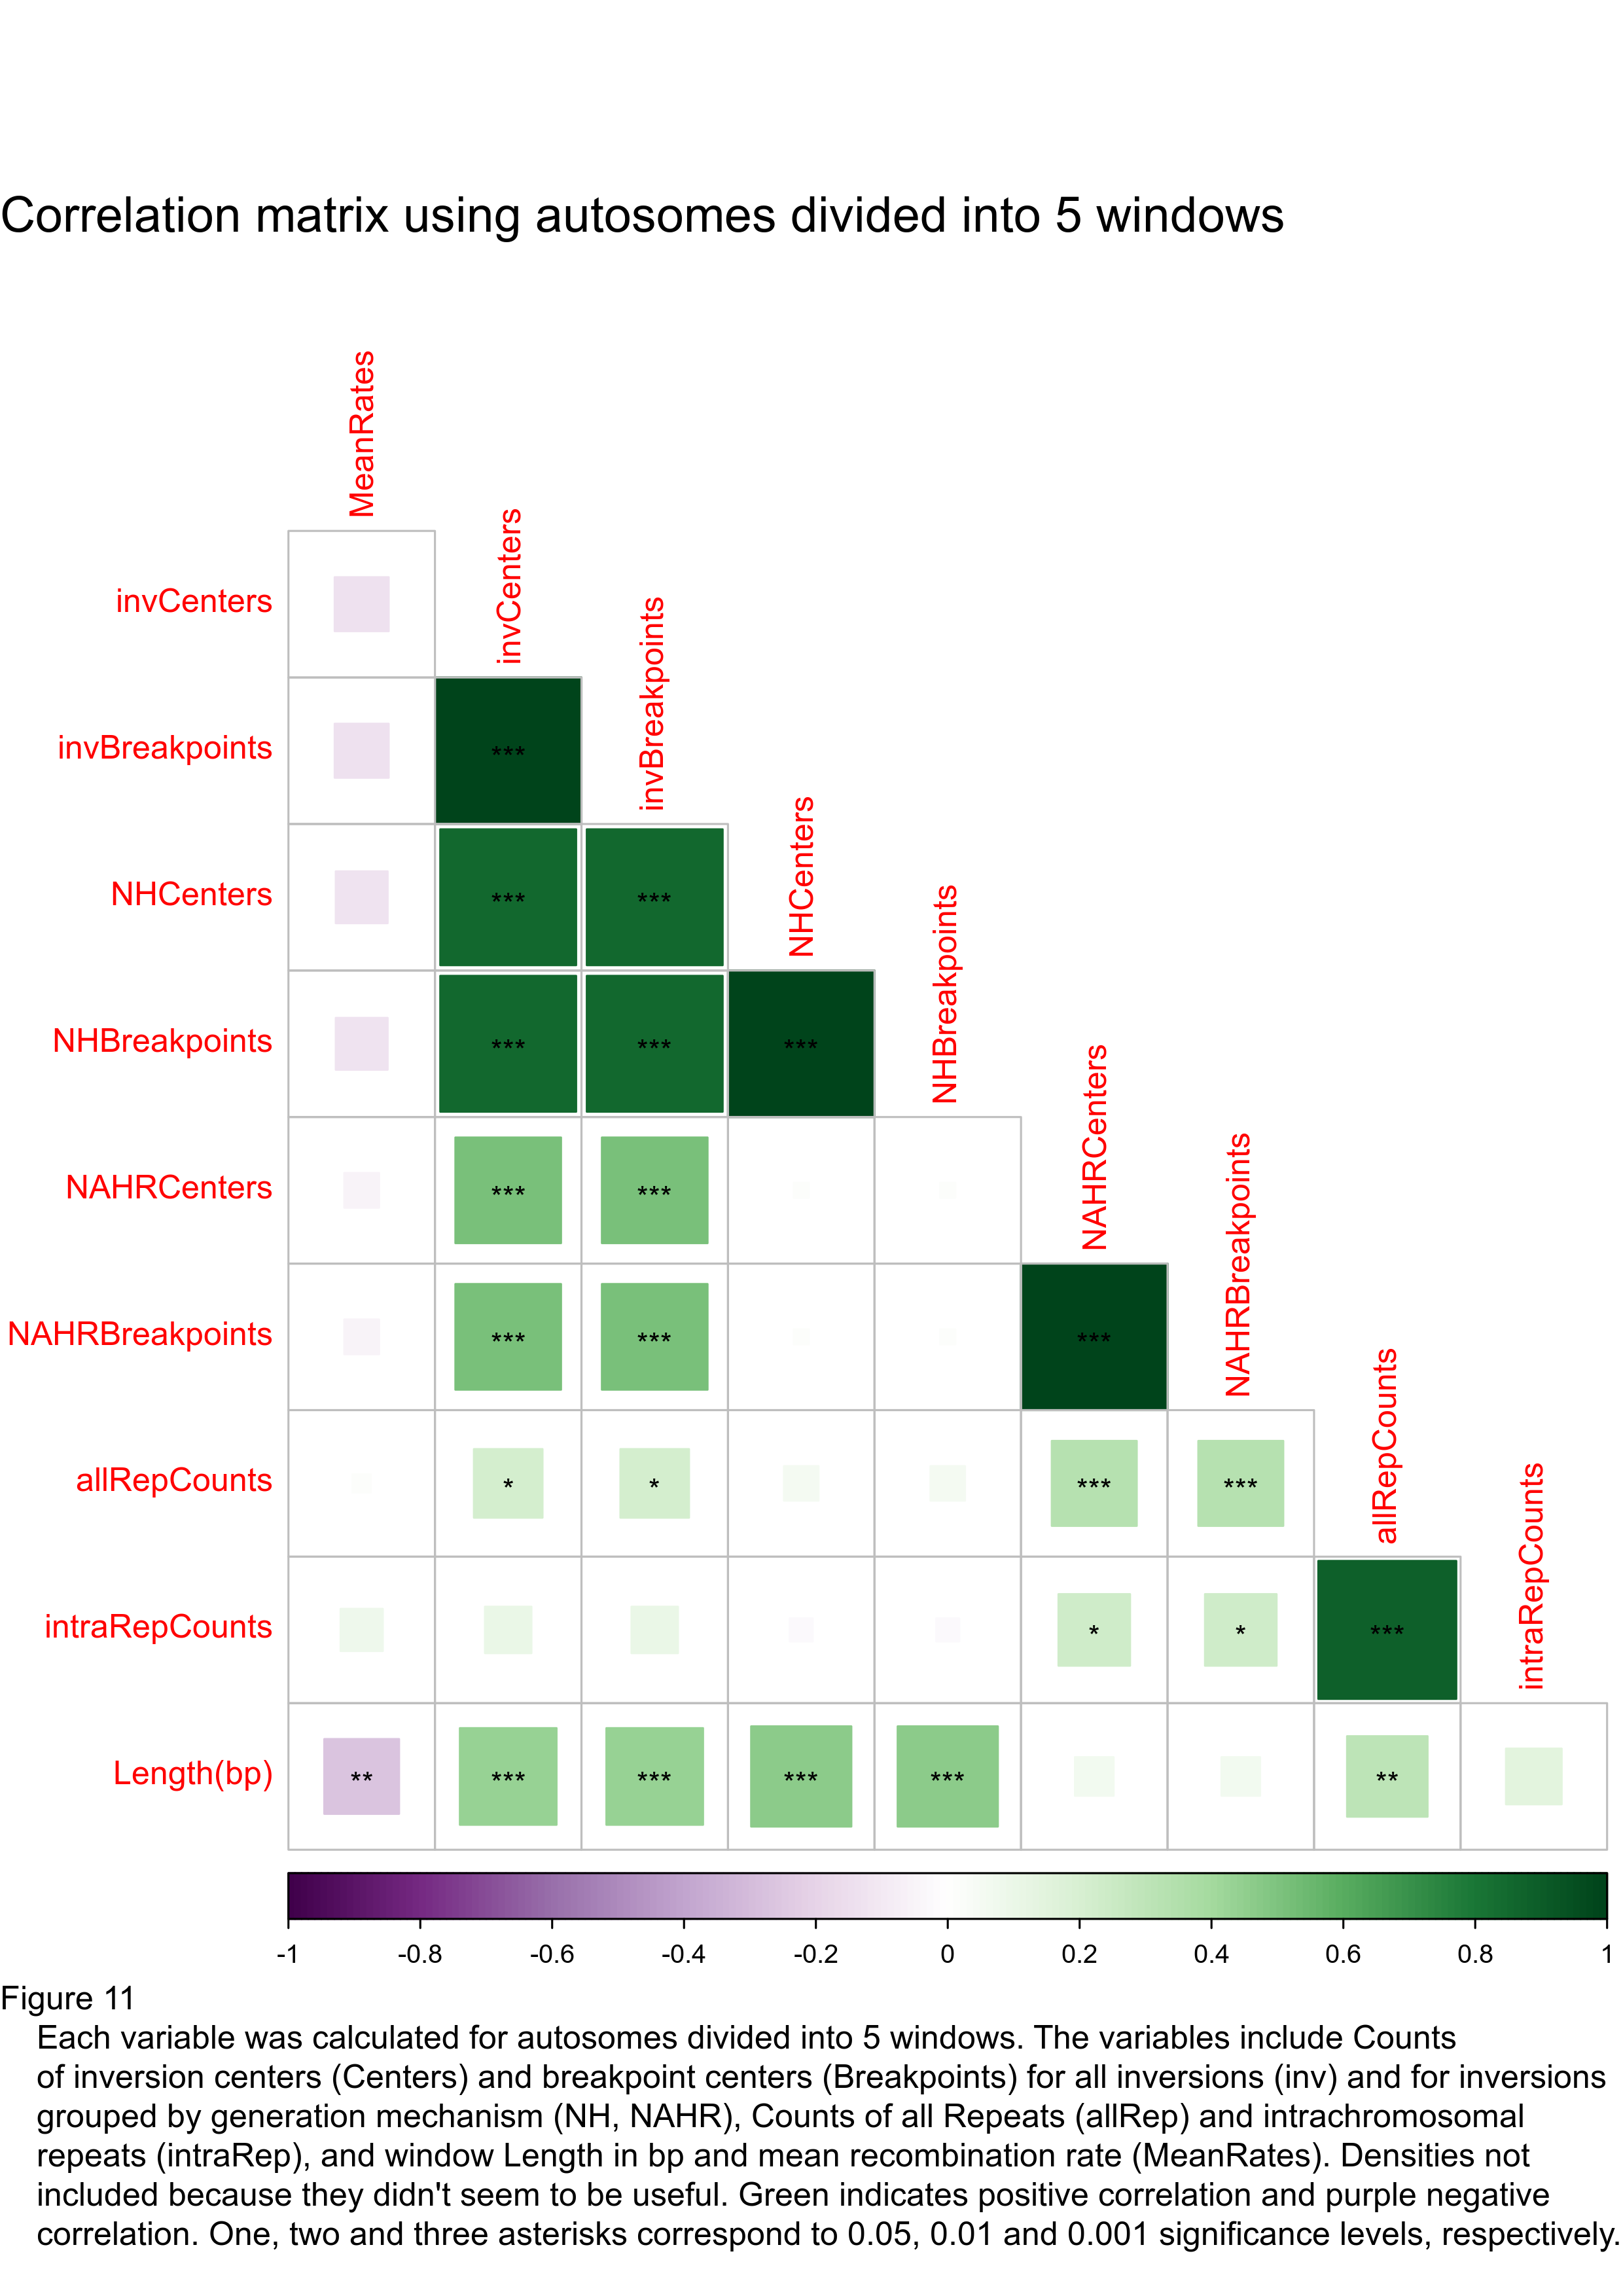

In [32]:
%%R -i allChromRegions -i figcounter -i fragCount -h 3508 -w 2480 -r 300 -n

library("corrplot")

rownames(allChromRegions) <- paste0(allChromRegions$Chromosome, allChromRegions$Positions)

toPlot <- allChromRegions[which(allChromRegions$MeanRates > 0),!(colnames(allChromRegions) %in% c("Positions", "Positions_end", "Chromosome"))]

toPlotCor = cor(as.matrix(toPlot))
testRes = cor.mtest(toPlot, conf.level = 0.95)

corrplot(toPlotCor, p.mat = testRes$p, sig.level = c(0.001, 0.01, 0.05), pch.cex = 0.9, insig = 'label_sig', type = "lower", method = "square", col = COL2('PRGn'), diag = FALSE)
mtext(paste0("Correlation matrix using autosomes divided into ",fragCount," windows"), side = 3, cex=1.5, adj = 0, line = -2)
mtext(paste0("Figure ",figcounter," 
    Each variable was calculated for autosomes divided into ",fragCount," windows. The variables include Counts 
    of inversion centers (Centers) and breakpoint centers (Breakpoints) for all inversions (inv) and for inversions 
    grouped by generation mechanism (NH, NAHR), Counts of all Repeats (allRep) and intrachromosomal 
    repeats (intraRep), and window Length in bp and mean recombination rate (MeanRates). Densities not
    included because they didn't seem to be useful. Green indicates positive correlation and purple negative 
    correlation. One, two and three asterisks correspond to 0.05, 0.01 and 0.001 significance levels, respectively." 
    ), side = 1, adj = 0, cex = 1, line = 3)

In [33]:
# After simple correlation, autosomes in sections
figcounter += 1

## Comprehensive correlation matrices (with distributions and scatter plots)

R[write to console]: Loading required package: xts

R[write to console]: Loading required package: zoo

R[write to console]: 
Attaching package: ‘zoo’


R[write to console]: The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


R[write to console]: 
Attaching package: ‘PerformanceAnalytics’


R[write to console]: The following object is masked from ‘package:graphics’:

    legend




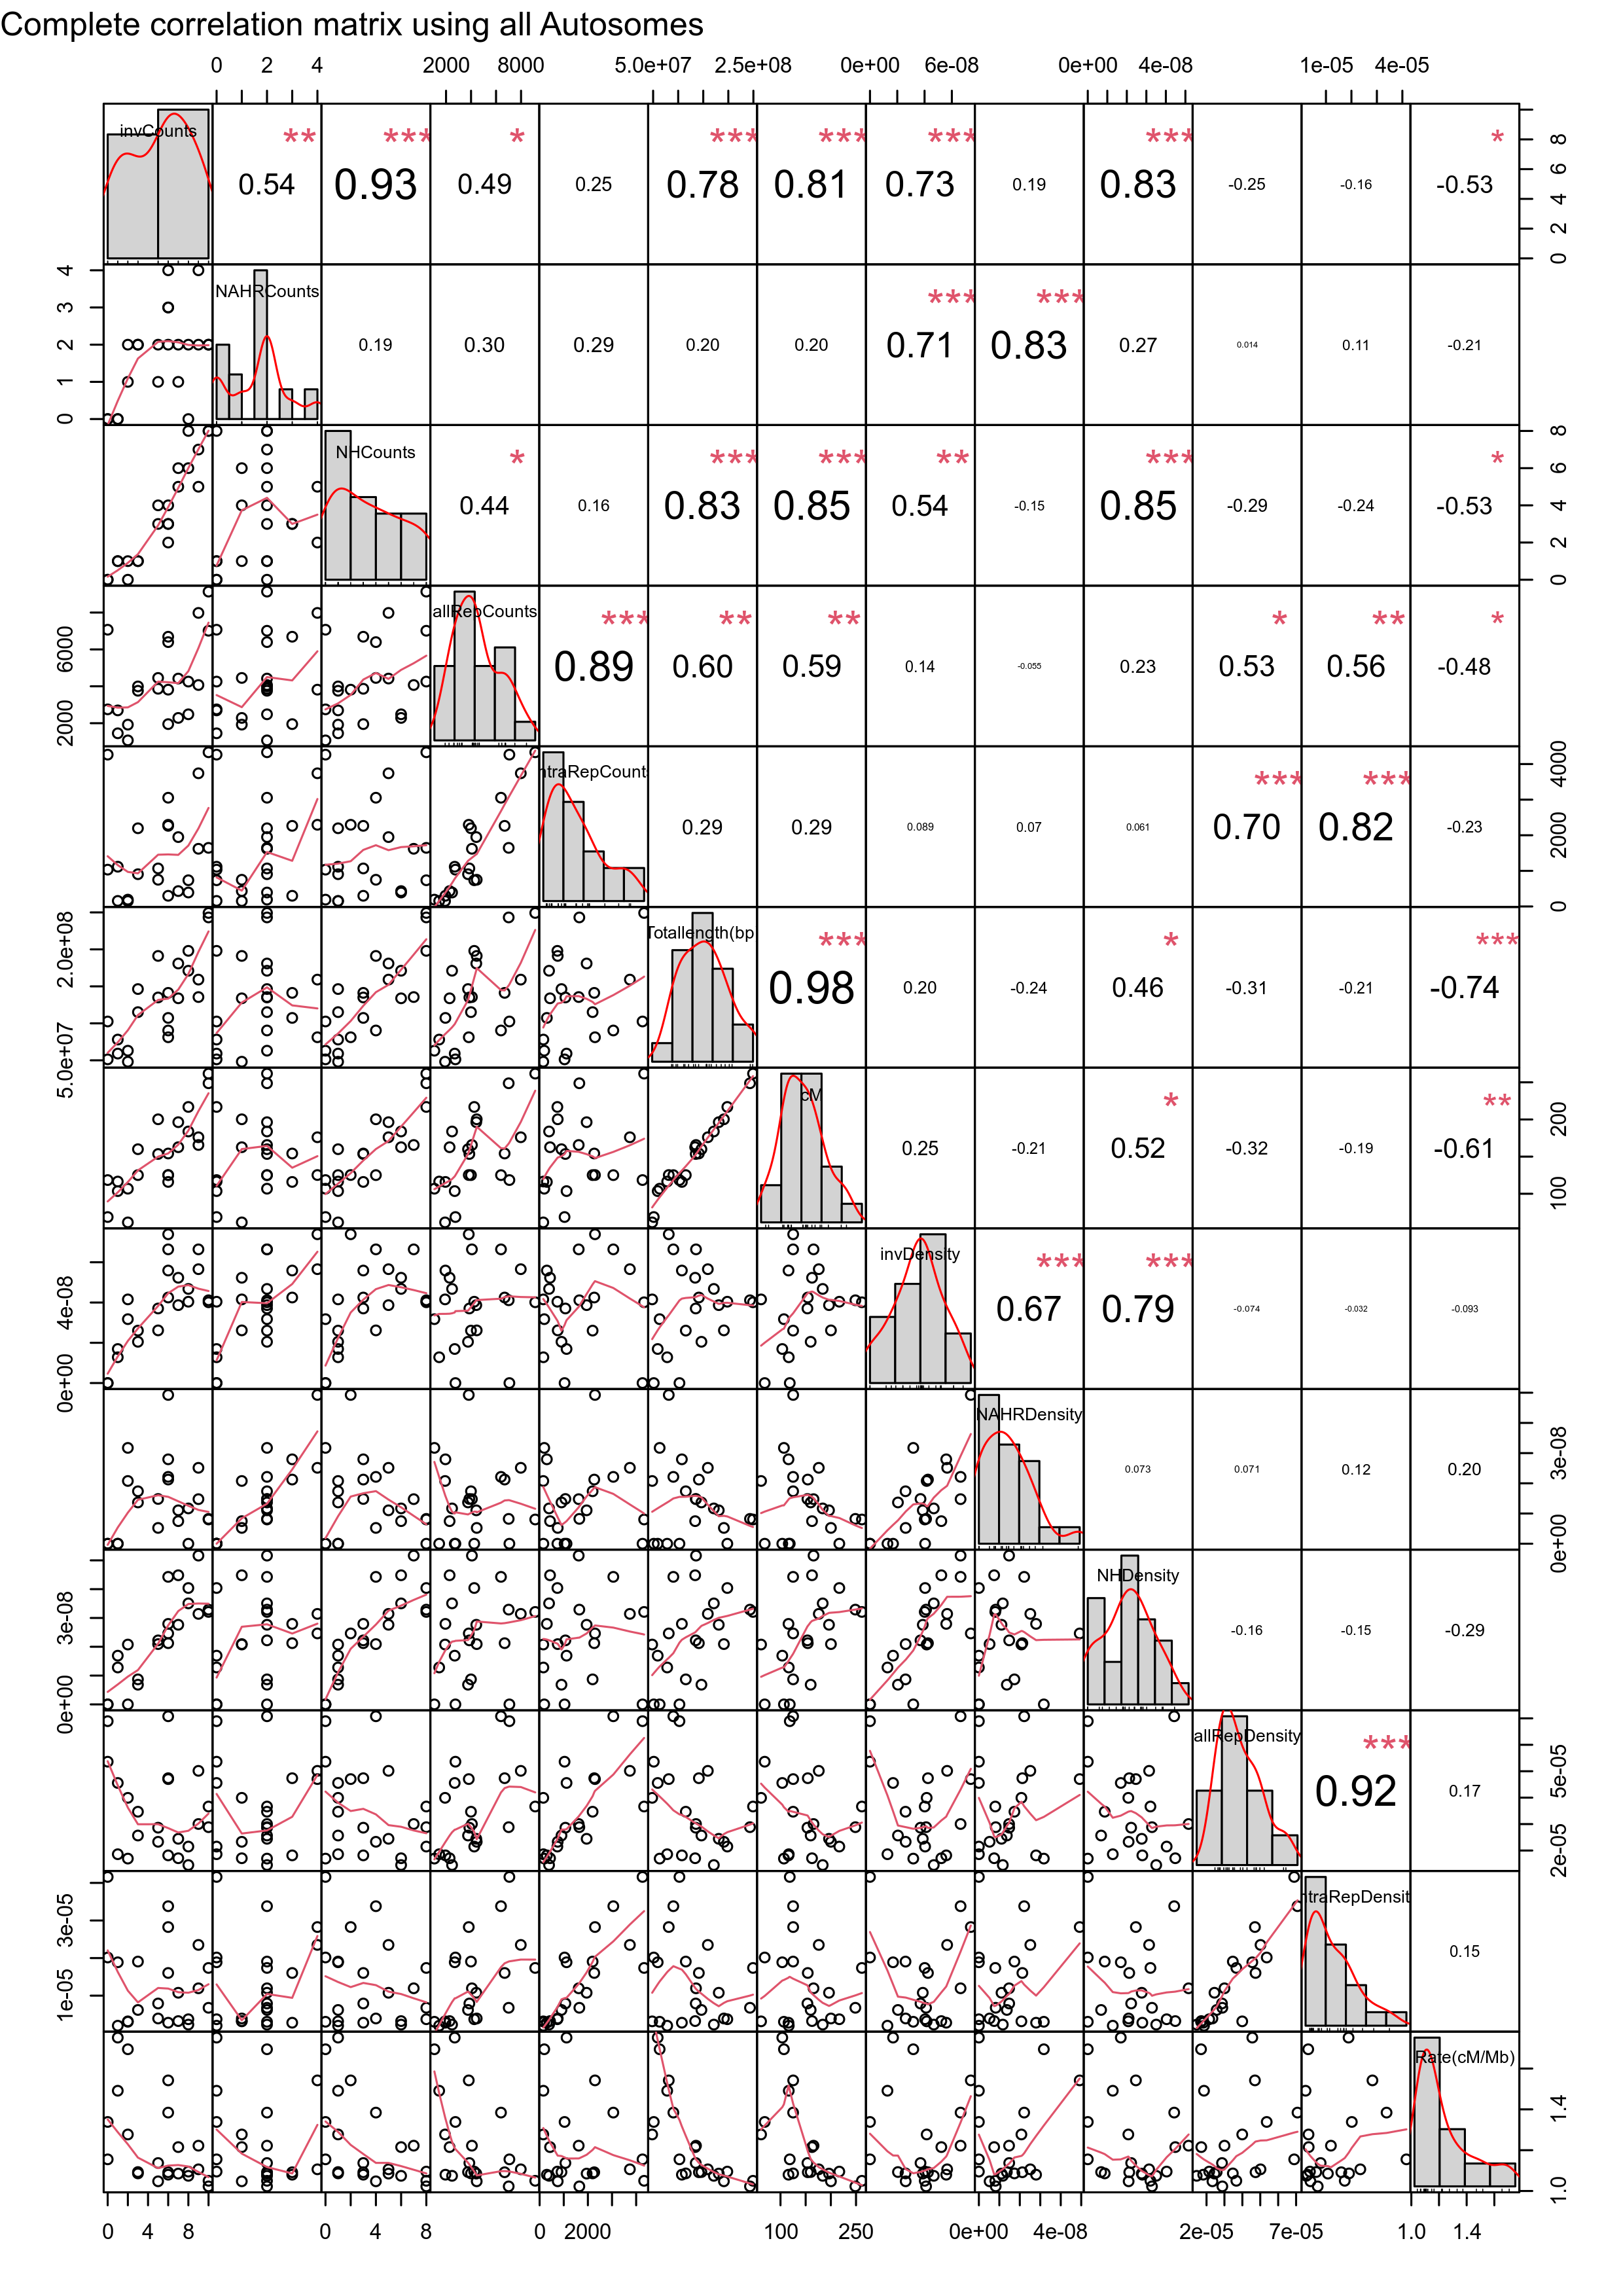

In [34]:
%%R -i Autosomes -h 3508 -w 2480 -r 300 -n
# 3508 x 2480 r 300
library("PerformanceAnalytics")

rownames(Autosomes) <- Autosomes$Chromosome

toPlot <- Autosomes[,c(3:ncol(Autosomes))]


chart.Correlation(toPlot, histogram=TRUE, pch = "+")

mtext("Complete correlation matrix using all Autosomes", side = 3, cex=1, line = 3, adj = 0)


In [35]:
# After complete correlation, all autosomes
print(f"Figure {figcounter}: \nCorrelation matrix using all autosomes. Variable distributions on the diagonal, bivariate scatter plots with a fitted lines in the bottom half, and value of the correlation and significance level on the top half. One, two and three asterisks correspond to 0.05, 0.01 and 0.001 significance levels, respectively.")
figcounter += 1

Figure 12: 
Correlation matrix using all autosomes. Variable distributions on the diagonal, bivariate scatter plots with a fitted lines in the bottom half, and value of the correlation and significance level on the top half. One, two and three asterisks correspond to 0.05, 0.01 and 0.001 significance levels, respectively.


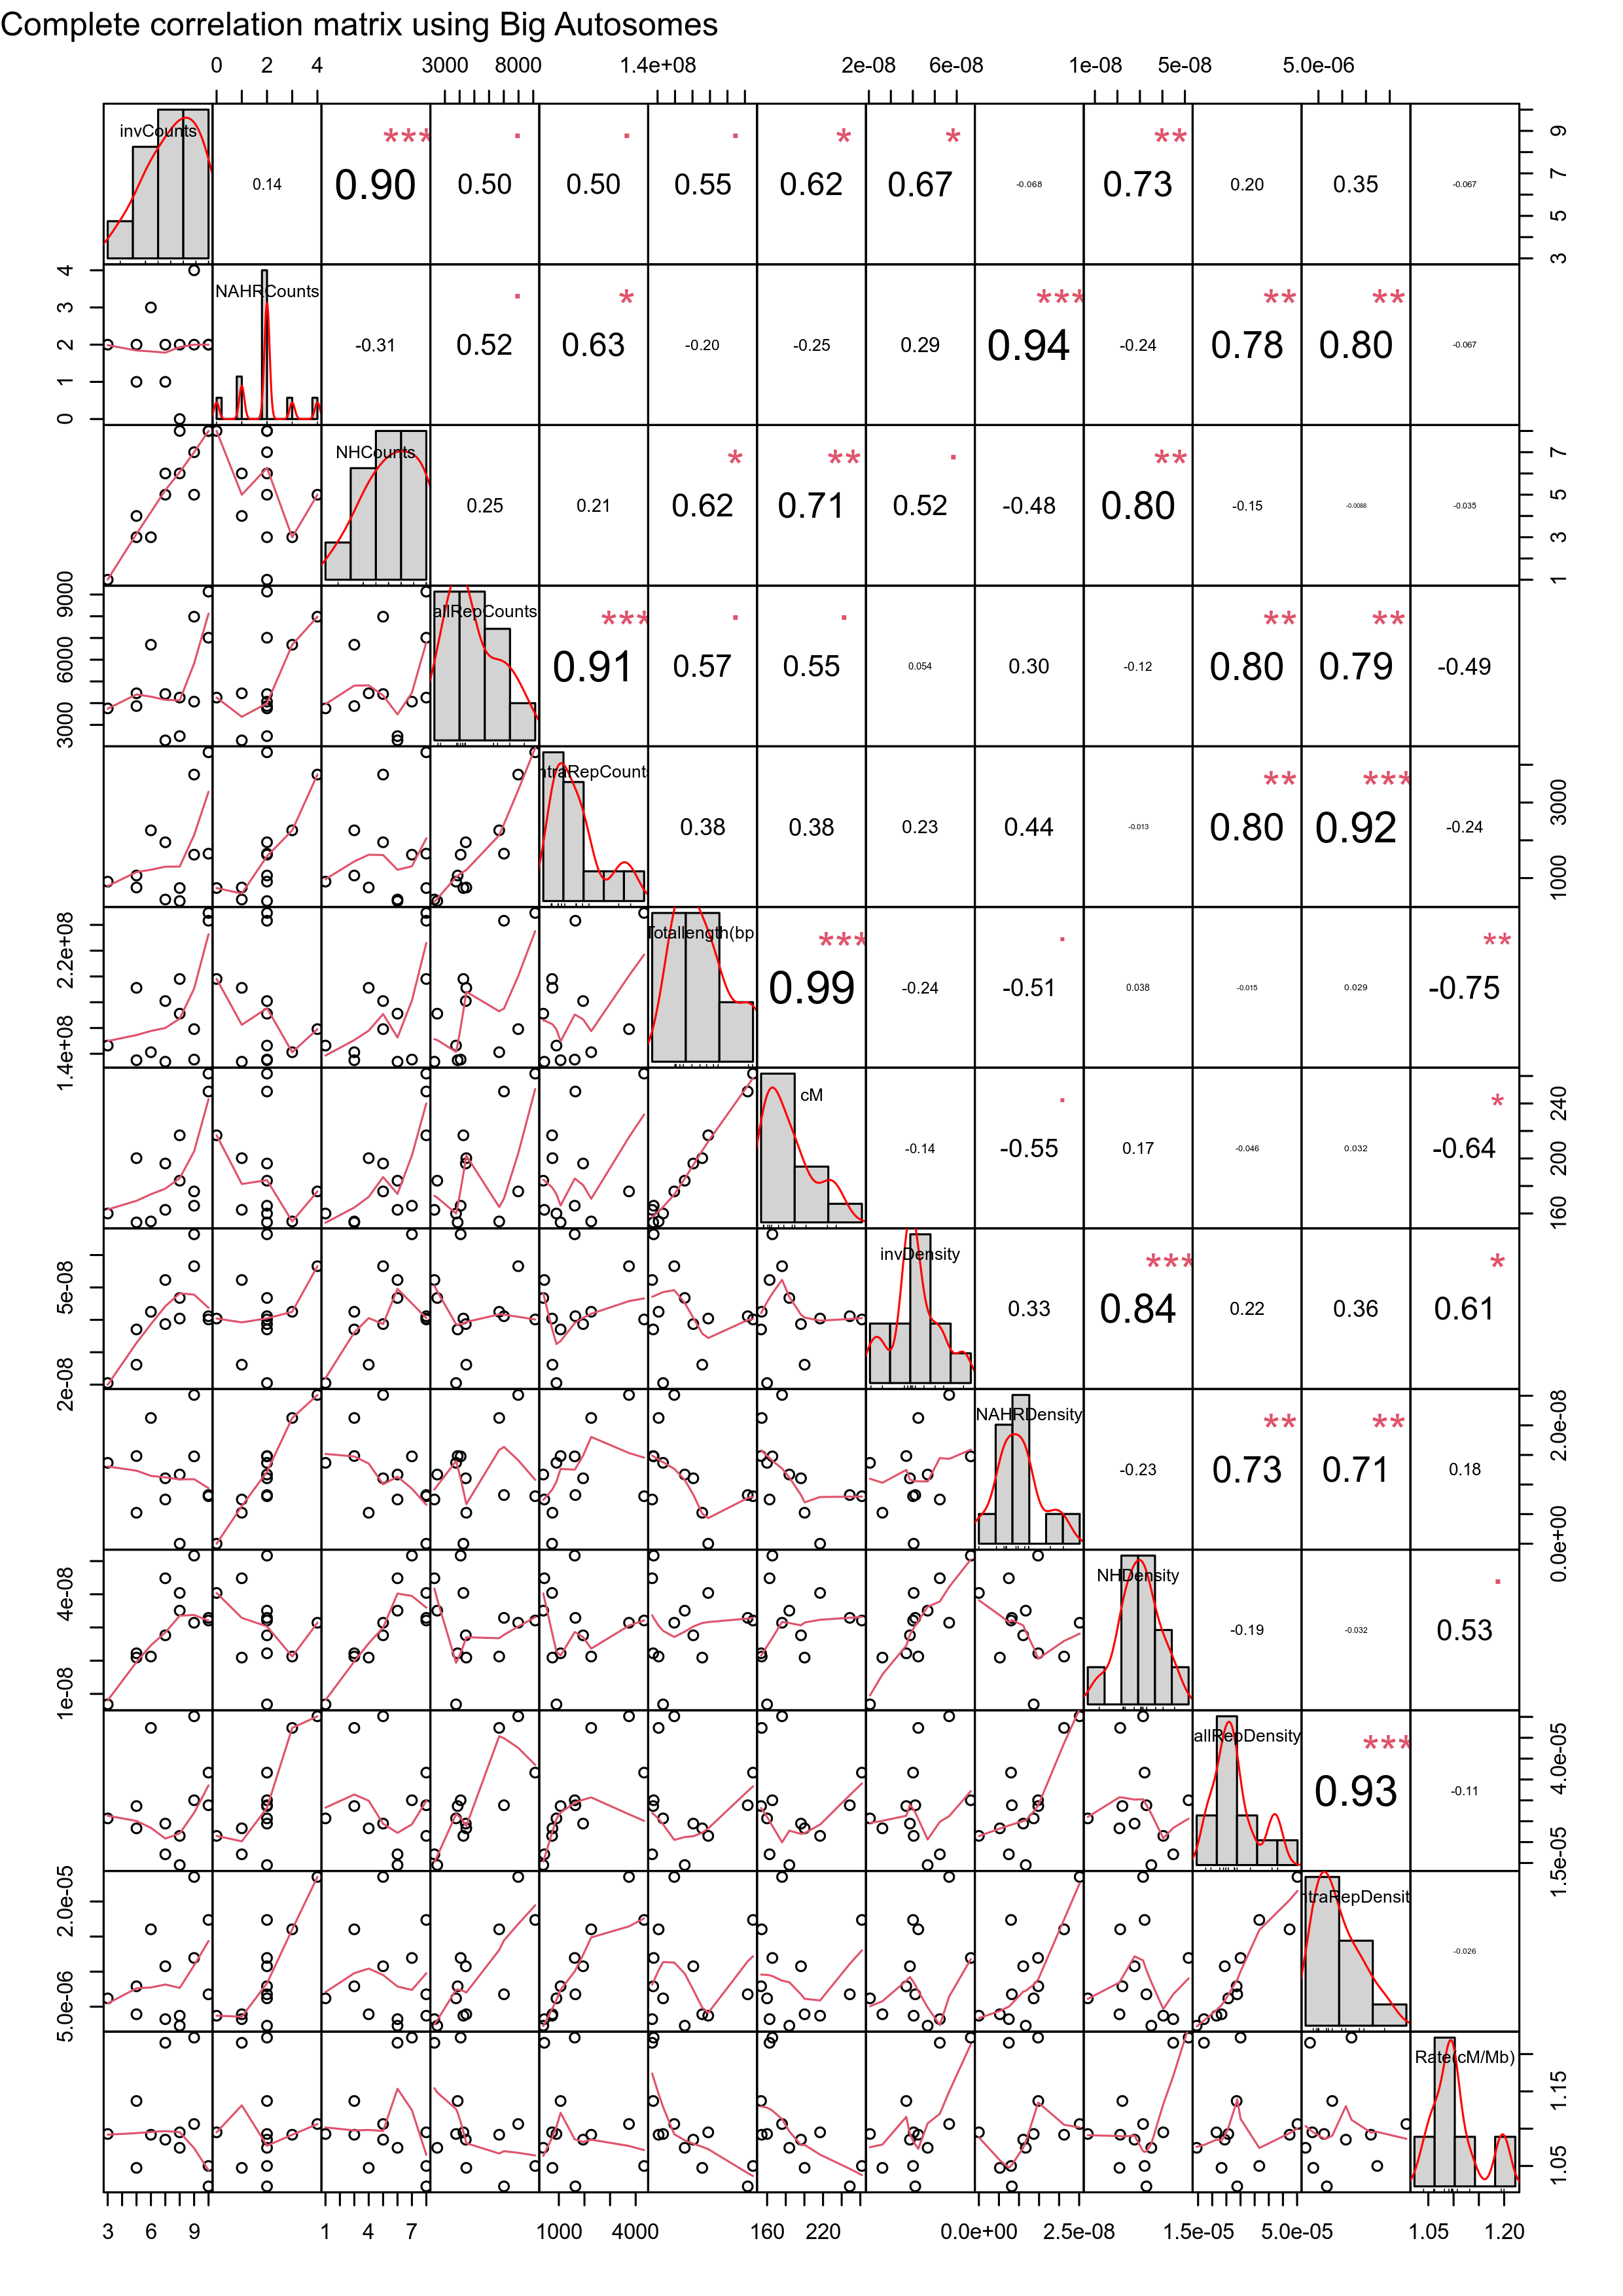

In [36]:
%%R -i Autosomes -h 3508 -w 2480 -r 300 -n
# 3508 x 2480 r 300
library("PerformanceAnalytics")
rownames(Autosomes) <- Autosomes$Chromosome

toPlot <- Autosomes[which(Autosomes$chromType == "BigAutosome" ),c(3:ncol(Autosomes))]

chart.Correlation(toPlot, histogram=TRUE)
mtext("Complete correlation matrix using Big Autosomes", side = 3, cex=1, line = 3, adj = 0)


In [37]:
# After complete correlation, big autosomes
print(f"Figure {figcounter}: \nCorrelation matrix using autosomes 1 to 12.  Variable distributions on the diagonal, bivariate scatter plots with a fitted lines in the bottom half, and value of the correlation and significance level on the top half. One, two and three asterisks correspond to 0.05, 0.01 and 0.001 significance levels, respectively.")
figcounter += 1

Figure 13: 
Correlation matrix using autosomes 1 to 12.  Variable distributions on the diagonal, bivariate scatter plots with a fitted lines in the bottom half, and value of the correlation and significance level on the top half. One, two and three asterisks correspond to 0.05, 0.01 and 0.001 significance levels, respectively.


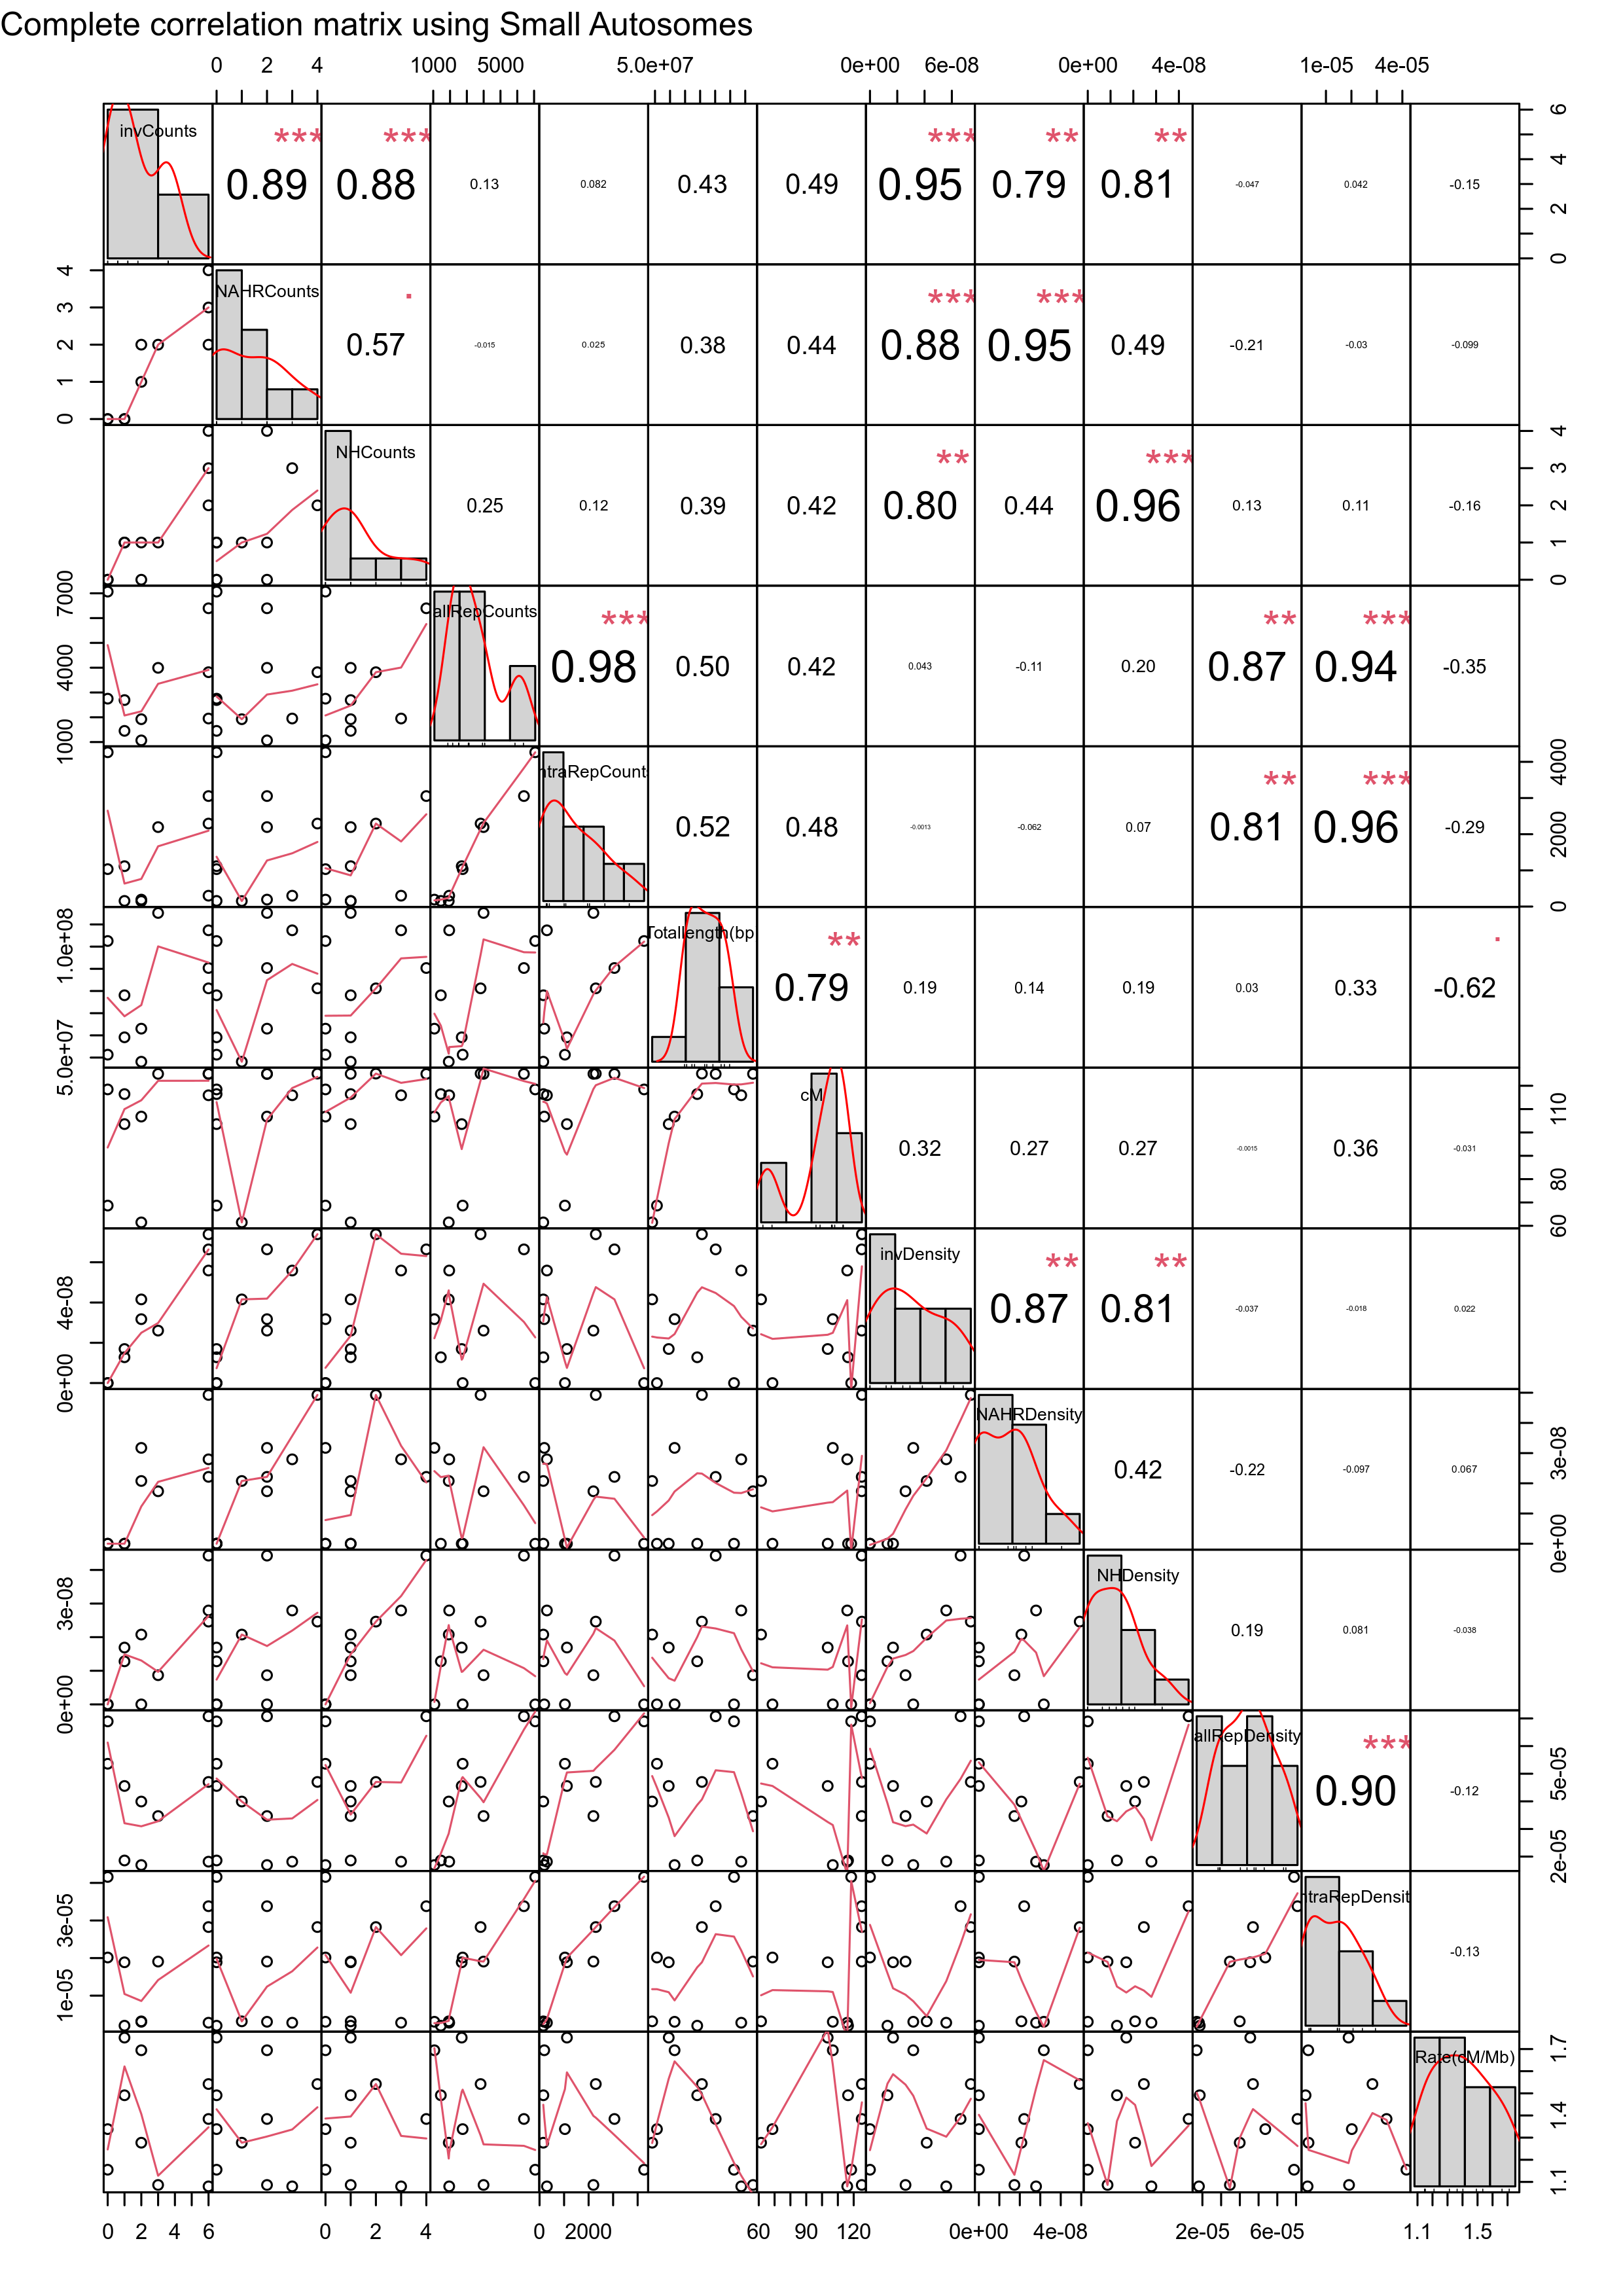

In [38]:
%%R -i Autosomes -h 3508 -w 2480 -r 300 -n
# 3508 x 2480 r 300
library("PerformanceAnalytics")
rownames(Autosomes) <- Autosomes$Chromosome

toPlot <- Autosomes[which(Autosomes$chromType == "SmallAutosome" ),c(3:ncol(Autosomes))]

chart.Correlation(toPlot, histogram=TRUE)
mtext("Complete correlation matrix using Small Autosomes", side = 3, cex=1, line = 3, adj = 0)


In [39]:
# After complete correlation, small autosomes
print(f"Figure {figcounter}: \nCorrelation matrix using autosomes 13 to 22. Variable distributions on the diagonal, bivariate scatter plots with a fitted lines in the bottom half, and value of the correlation and significance level on the top half. One, two and three asterisks correspond to 0.05, 0.01 and 0.001 significance levels, respectively.")
figcounter += 1

Figure 14: 
Correlation matrix using autosomes 13 to 22. Variable distributions on the diagonal, bivariate scatter plots with a fitted lines in the bottom half, and value of the correlation and significance level on the top half. One, two and three asterisks correspond to 0.05, 0.01 and 0.001 significance levels, respectively.


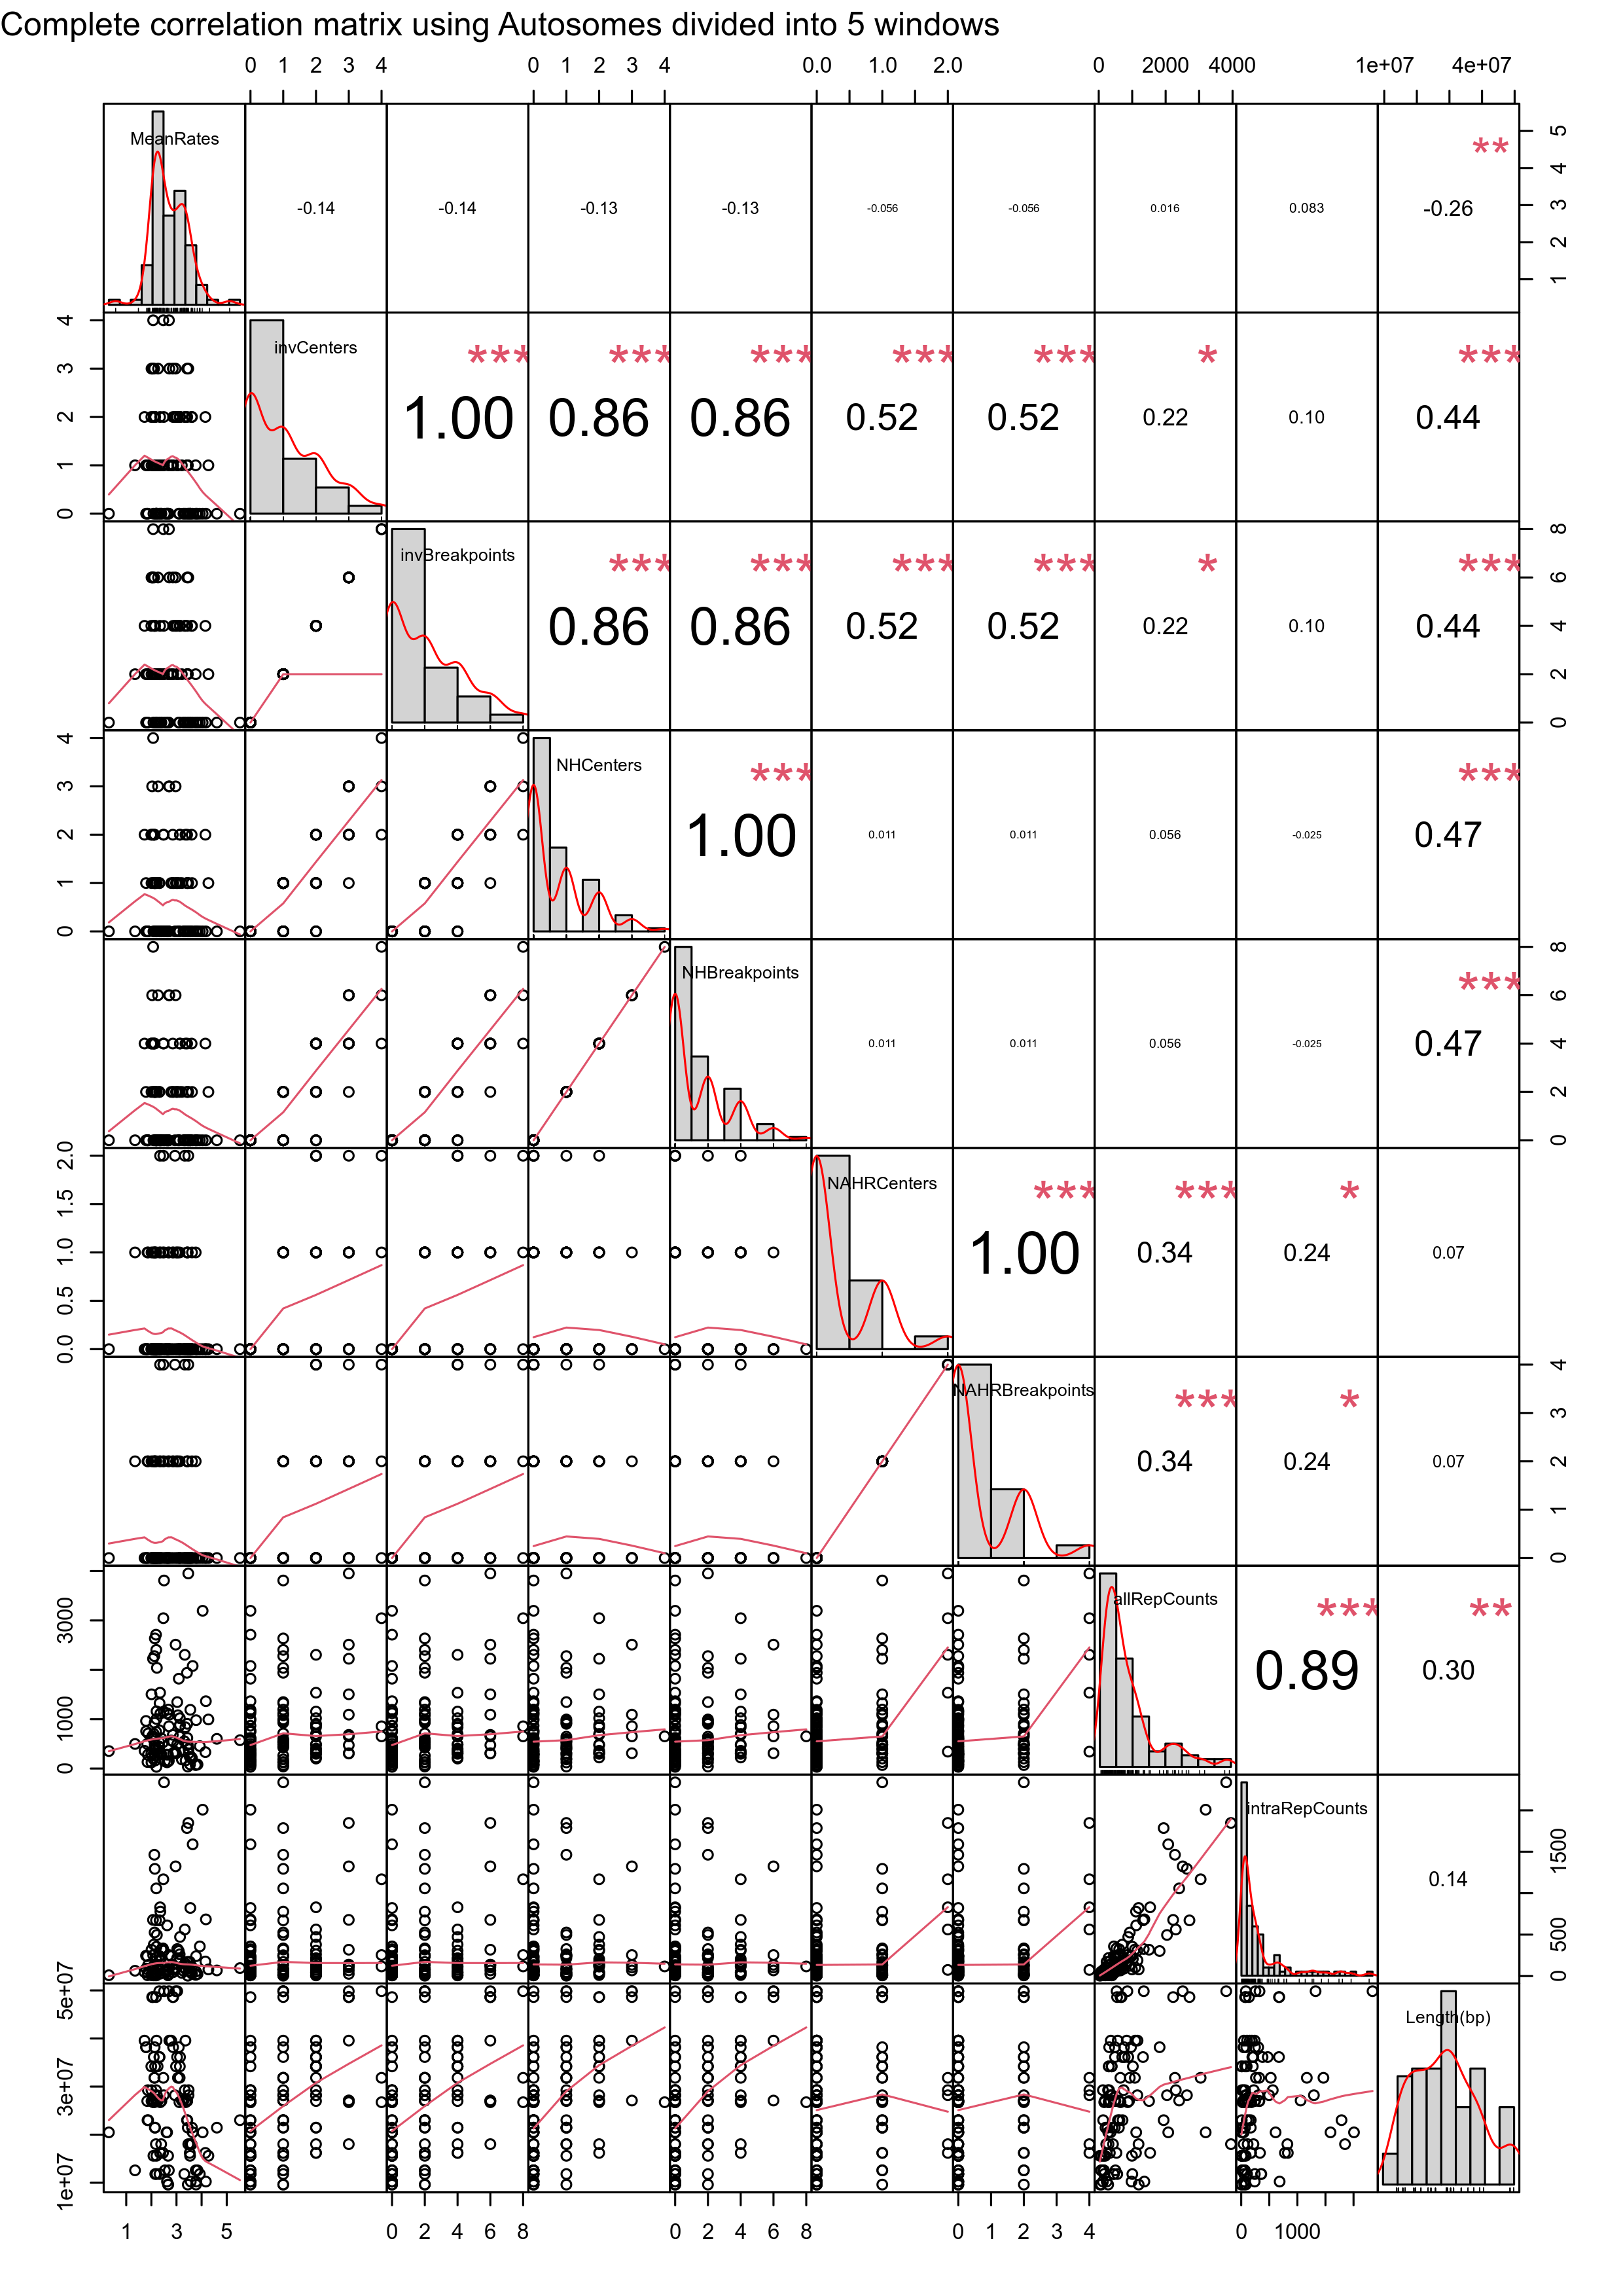

In [40]:
%%R -i allChromRegions -i fragCount -h 3508 -w 2480 -r 300 -n

library("PerformanceAnalytics")


rownames(allChromRegions) <- paste0(allChromRegions$Chromosome, allChromRegions$Positions)

# toPlot <- allChromRegions[which(!is.na(allChromRegions$MeanRates)),!(colnames(allChromRegions) %in% c("Positions", "Positions_end", "Chromosome"))]
toPlot <- allChromRegions[which(allChromRegions$MeanRates > 0),!(colnames(allChromRegions) %in% c("Positions", "Positions_end", "Chromosome"))]


chart.Correlation(toPlot, histogram=TRUE, pch = "+")
mtext(paste0("Complete correlation matrix using Autosomes divided into ",fragCount," windows"), side = 3, cex=1, line = 3, adj = 0)


In [41]:
print(f"Figure {figcounter}: \nCorrelation matrix using all autosomes, divided into {fragCount} windows. Variable distributions on the diagonal, bivariate scatter plots with a fitted lines in the bottom half, and value of the correlation and significance level on the top half. One, two and three asterisks correspond to 0.05, 0.01 and 0.001 significance levels, respectively.")
figcounter += 1

Figure 15: 
Correlation matrix using all autosomes, divided into 5 windows. Variable distributions on the diagonal, bivariate scatter plots with a fitted lines in the bottom half, and value of the correlation and significance level on the top half. One, two and three asterisks correspond to 0.05, 0.01 and 0.001 significance levels, respectively.


## Previous test : not comprehensive correlations with chromosome characteristics
<!---  
This section is from the Supplementary, it sure has everything needed
--->

In [42]:
# SUPCONTENT: Distribution of inversions by chromosome size
# -------------------------------

# Take chromosome sizes
chromSize = gap[(gap.type == "telomere") & (gap.chromStart!=0)][["chrom", "chromEnd"]]

# # Join with inversion count
prop = pd.merge(chromSize, hist, left_on="chrom", right_on = "chrNames" )

# # Plot correlation
plotSubset = prop[~prop["chrNames"].isin(["chrX", "chrY"])]


R[write to console]: Loading required package: ggplot2

R[write to console]: `geom_smooth()` using formula 'y ~ x'



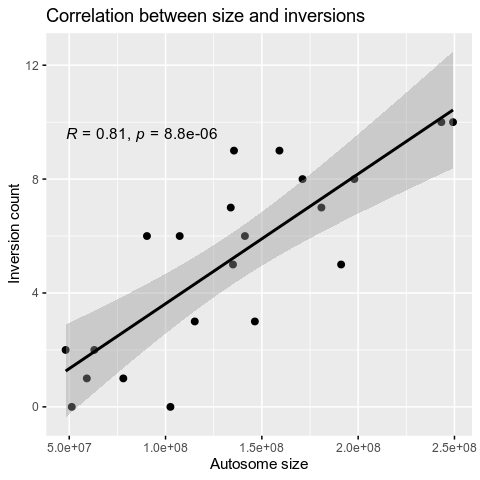

In [43]:
%%R -i plotSubset -r 100 -n

library(ggpubr)

ggscatter(plotSubset, x = "chromEnd", y = "Chr",
          add = "reg.line",                                 
          conf.int = TRUE,                                  
          add.params = list(color = "black",
                            fill = "gray60"),
          ggtheme = theme_gray() 
        )+
  stat_cor(method = "pearson")+
  ggtitle("Correlation between size and inversions ")+
  ylab("Inversion count")+xlab("Autosome size")  


In [44]:
# After correlation between autosome size and inversion count with all
print(f"Figure {figcounter}: There is a moderate, significant positive correlation between autosome size and inversion count when all inversions and autosomes are considered.")
figcounter+=1

Figure 16: There is a moderate, significant positive correlation between autosome size and inversion count when all inversions and autosomes are considered.


In [ ]:
# SUPCONTENT : Distribution of inversions by chromosome size, grouped 
# -------------------------------

# IC_CT_auto = ICounts_CTypes[ ~ ICounts_CTypes["chrNames"].isin(["chrX", "chY"])]



R[write to console]: `geom_smooth()` using formula 'y ~ x'



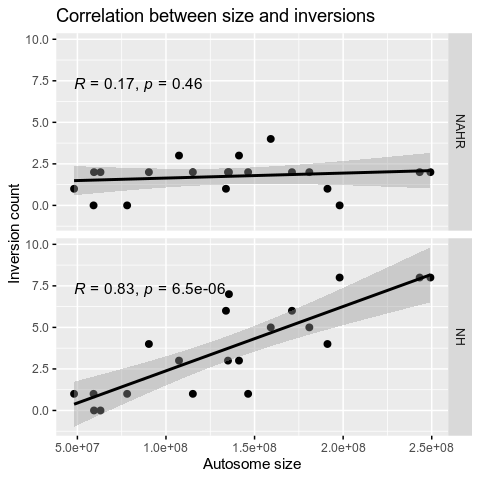

In [ ]:
%%R -i IC_CT_auto -r 100 -n

library(ggpubr)

ggscatter(IC_CT_auto, x = "chromEnd", y = "value",
          add = "reg.line",                                 
          conf.int = TRUE,                                  
          add.params = list(color = "black",
                            fill = "gray60"),
          ggtheme = theme_gray() 
        )+
  stat_cor(method = "pearson")+
  facet_grid(OriginFixed ~ .)+ 
  ggtitle("Correlation between size and inversions")+
  ylab("Inversion count")+xlab("Autosome size")


In [ ]:
# After corrleation between autosome size and inversion count
print(f"Figure {figcounter}: The correlation between Autosome size and inversion count is affected by the differential distributions observed in Figure {figcounter-1}. NH inversion counts show a strong, significant positive correlation with chromosome size, while no such correlation is observed for NAHR inversions because of their excess in Small chromosomes and depleat Big chromosomes." )
figcounter+=1

Figure 17: The correlation between Autosome size and inversion count is affected by the differential distributions observed in Figure 16. NH inversion counts show a strong, significant positive correlation with chromosome size, while no such correlation is observed for NAHR inversions because of their excess in Small chromosomes and depleat Big chromosomes.


In [ ]:
# SEGMENTAL DUPLICATIONS
# -----------------------------

# Make per-chromosome repeat counts
# Filter intrachromosomal segDups
sD_intra = segDups[segDups.chrom == segDups.otherChrom]
sD_grouped = sD_intra.groupby(["chrom" ])
# Count
sD_groupedIDs = sD_grouped["name"]
sD_counted = DataFrame(sD_groupedIDs.size())

# Add chromosome size
sD_prop = pd.merge(sD_counted, chromSize, left_on = "chrom", right_on="chrom")
sD_prop["RepsPerMb"] = sD_prop["name"] / (sD_prop["chromEnd"]/1000000)

# Merge with inversion counts
repInvs =pd.merge(ICounts_CTypes, sD_prop, left_on = "Chr", right_on="chrom", how = "left")

# DELETE THIS TO INCLUDE SEXUAL CHROMOSOMES
repInvs = repInvs[  ~ repInvs.Chr.isin(["chrX", "chrY"]) ]



In [ ]:
%%R -i repInvs -r 100 -n

library(ggpubr)

ggscatter(repInvs, x = "name", y = "value",
          add = "reg.line",                                 
          conf.int = TRUE,                                  
          add.params = list(color = "black",
                            fill = "gray60"),
          ggtheme = theme_gray() 
        )+
  stat_cor(method = "pearson")+
  facet_grid(OriginFixed ~ .)+ 
  ggtitle("Correlation between segdups and inversion count \n(autosomes)")+
  ylab("Inversion count")+xlab("Intrachromosomal Segmental Duplications count") 


In [ ]:
inv["InvSize"] = inv["BP2_2.1"] - inv["BP1_1.1"] +1
inv["logInvSize"] = np.log10(inv["InvSize"])
(
    ggplot(inv)+
    geom_boxplot(aes(x = "chrTypes", y = "logInvSize"))+
    facet_grid(". ~ OriginFixed")+
    ggtitle("Distribution of inversions sizes")+
    xlab("Chromosome types")+ylab("log10(Inversion sizes)")  

)

In [ ]:

print(f"Figure {figcounter}: Inversion sizes seem to be evenly distributed across chromosome types. " )
figcounter+=1

## Previous test: Distribution along chromosome arms 

In [ ]:
# CONTENT Calculate chromosome arms and centered inversions
# ---------------------------------------

# Select centromeres as p arm End
center = band[(band['gieStain'] == 'acen') & (band['name'].str.startswith('p') )]
center = center[['chrom', 'chromEnd']]

# Select chromosome end as q arm End
groupedBand = band['chromEnd'].groupby(band['chrom'])
end = DataFrame(groupedBand.max() )
end.reset_index(level=['chrom'], inplace = True)

# Set q arm Start
end = pd.merge(end, center, on = 'chrom')
end.set_axis(['chrom','chromEnd','chromStart'], axis = 1, inplace = True)

# Set p arm Start
center['chromStart'] = 0

# Set p and q flags
center['chromArm']='p'
end['chromArm']='q'

# Join data
chromArms = pd.concat([center, end])

# Armsize
chromArms["ArmSize"] = chromArms["chromEnd"] - chromArms["chromStart"] # no need to sum-rest, 0 based



# Calculate % of arm in which the center of the inversion is placed
# ---------------------------------------

# Make center of inversion
inv["Center_pos"] = inv["BP1_1.1"] + ((inv["BP2_2.1"]- inv["BP1_1.1"] +1 )/2) -1 # now it is 0-based

# For each inversion, calculate chromosome arm
inv["chromArm"] = [ chromArms[(chromArms.chromStart < row.Center_pos )& (chromArms.chromEnd > row.Center_pos) & (row.Chr == chromArms.chrom)]["chromArm"].iloc[0] for index, row in inv.iterrows() ]

# Calculate % of arm where inversion is, 0 = start, 100 = end
percList = []

for index, row in inv.iterrows():
    myrow = chromArms[(chromArms.chrom == row.Chr) & (chromArms.chromArm == row.chromArm)].iloc[0]
    value = ((row.Center_pos - myrow.chromStart ) / myrow.ArmSize ) * 100
    percList.append(value)

inv["armPerc"] = percList

# Change percentages to be 0 = centromere, 100 = telomere
mask = (inv.chromArm == "p")
inv_valid = inv[mask]

inv["armPerc_Telocen"] = inv["armPerc"]
inv.loc[mask, 'armPerc_Telocen'] = 100 - inv_valid["armPerc"]

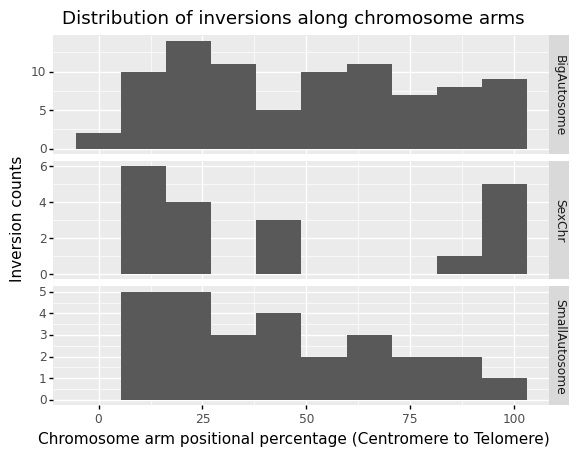

<ggplot: (8786104154188)>

In [ ]:
(
    ggplot(inv)+
    geom_histogram(aes(x = "armPerc_Telocen"), bins=10)+
    facet_grid("chrTypes ~ .", scales = "free")+
    ggtitle("Distribution of inversions along chromosome arms")+
    xlab("Chromosome arm positional percentage (Centromere to Telomere)")+ylab("Inversion counts")  
)

In [51]:

print(f"Figure {figcounter}: Distribution of inversion counts along chromosome arms, where 0 is the centromere and 100 is the telomere. Inversions seem to be located preferently around centromeres when not taking into account inversion origin, although in Sex chromosomes an Small Autosomes the first bin, most proximal to the centromere, is empty." )
figcounter+=1

Figure 18: Distribution of inversion counts along chromosome arms, where 0 is the centromere and 100 is the telomere. Inversions seem to be located preferently around centromeres when not taking into account inversion origin, although in Sex chromosomes an Small Autosomes the first bin, most proximal to the centromere, is empty.


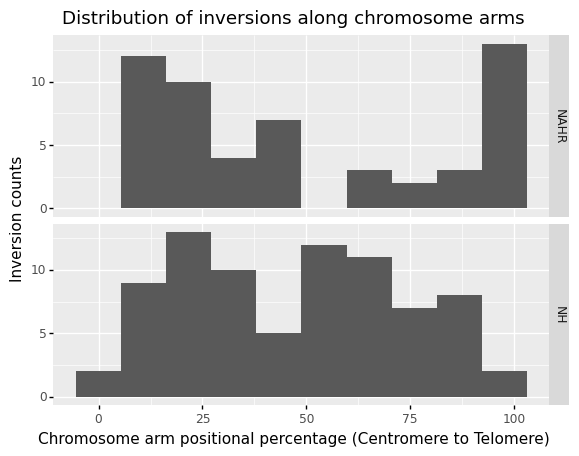

<ggplot: (8786104154197)>

In [ ]:
(
    ggplot(inv)+
    geom_histogram(aes(x = "armPerc_Telocen"), bins=10)+
    facet_grid("OriginFixed ~ .", scales = "free")+
    ggtitle("Distribution of inversions along chromosome arms")+
    xlab("Chromosome arm positional percentage (Centromere to Telomere)")+ylab("Inversion counts")  
)

In [52]:

print(f"Figure {figcounter}: Distribution of inversion counts along chromosome arms, where 0 is the centromere and 100 is the telomere. NAHR inversions are preferently located near centromeres and telomeres, while NH inversions seem to be more dsitributed along the chromosome arm. " )
figcounter+=1

Figure 19: Distribution of inversion counts along chromosome arms, where 0 is the centromere and 100 is the telomere. NAHR inversions are preferently located near centromeres and telomeres, while NH inversions seem to be more dsitributed along the chromosome arm. 


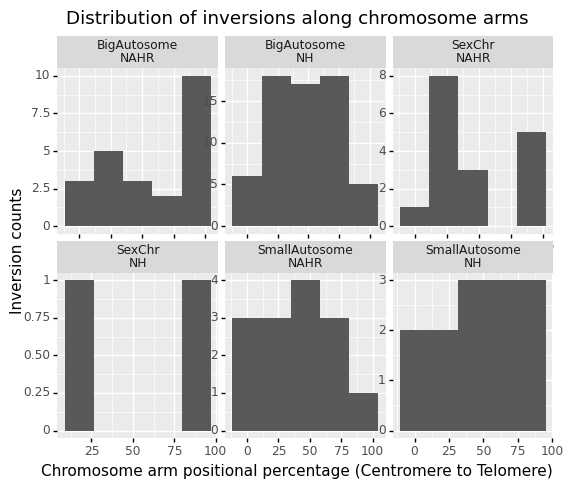

<ggplot: (8786104163892)>

In [ ]:
(
    ggplot(inv)+
    geom_histogram(aes(x = "armPerc_Telocen"), bins=5)+
    facet_wrap("~ chrTypes + OriginFixed", scales = "free")+
    ggtitle("Distribution of inversions along chromosome arms")+
    xlab("Chromosome arm positional percentage (Centromere to Telomere)")+ylab("Inversion counts")  
)

In [53]:

print(f"Figure {figcounter}: Distribution of inversion counts along chromosome arms, where 0 is the centromere and 100 is the telomere. When looking at all the categories, we loose definition, especially for small chromosomes. The most evident patterns can be observed in Big chromosomes: NH inversions concentrate in the middle of the chromosome arm while most NAHR generate near telomeres." )
figcounter+=1

Figure 20: Distribution of inversion counts along chromosome arms, where 0 is the centromere and 100 is the telomere. When looking at all the categories, we loose definition, especially for small chromosomes. The most evident patterns can be observed in Big chromosomes: NH inversions concentrate in the middle of the chromosome arm while most NAHR generate near telomeres.


In [ ]:
chrom_start = 0
chrom_end = 125000000 # chromosome 1 p arm size
inv_size = inv[inv.OriginFixed == "NH"]["InvSize"] /2
multiplicator = 10

random.seed(1)
choices = np.array([random.randint(chrom_start, chrom_end) for _ in range(inv_size.count() * multiplicator) ])

choices_start = choices - inv_size.repeat(multiplicator) /2
choices_end = choices + inv_size.repeat(multiplicator) /2

accepted = choices[(choices_start >= 0) & (choices_end <= chrom_end)]

(
    ggplot(DataFrame(accepted))+
    geom_histogram(aes(x = "accepted"), bins = 5)+
    ggtitle("Distribution of randomly generated fragments")+
    xlab("Chromosome arm positional percentage (Centromere to Telomere)\n Simulated chr1.p")+ylab("Simulated inversion counts")  
)

In [ ]:

print(f"Figure {figcounter}: Simulated distribution of inversions along a chromosome arm. One random point in the map was assigned to each of the {inv_size.count()} NH inversions, and then the corresponding breakpoints calculated according to inversion size. If inversion breakpoints fell outside the map limits, the inversion was discarded. This process was repeated {multiplicator} times." )
figcounter+=1